# Анализ временных рядов - практика

<img src='https://www.timescale.com/blog/content/images/size/w2000/2023/10/Screenshot-2023-10-11-at-7.16.17-PM.png'>

### В этой практике

- Обсудим задачу прогноза временных рядов
- Изучим временной ряд - посещения веб-страницы
- Спрогнозируем количество посещений веб-страницы 

Библиотеки: pandas, numpy, seaborn, matplotlib, statsmodels, prophet, sklearn

### Перед началом

Для практики понадобится библиотека prophet - для прогноза временных рядов. Prophet появился в 2017 и зарекомендовал себя как удобный и качественный инструмент для работы с временными рядами, особенно с данными, у которых есть сложная сезонность - как по неделям, так и по месяцам. В части обучения моделей работа с prophet очень похожа на работу с sklearn.

Библиотека не входит в стандартный набор доступных библиотек, поэтому нужно установить.
Следующая строчка кода позволит установить библиотеку и использовать ее:

In [1]:
#!python -m pip install prophet

### Основные библиотеки

Библиотеки и функции, которые используются в основной части тетрадки

In [2]:
# для работы с таблицей
import pandas as pd
# для математических трансформаций
import numpy as np
# для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# метрики
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

In [4]:
# для анализа временных рядов
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [5]:
# умная модель для прогноза
from prophet import Prophet

In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## 1. О временных рядах

Под временным рядом мы понимаем последовательность наблюдений за величиной в равные промежутки времени:
$$ y_1, y_2, y_3, ..., y_t$$

**Примеры временных рядов**:

- ВВП страны (и другие финансовые и экономические показатели) 
- стоимость акций компании
- температура воздуха
- спрос на товар в интернет-магазине
- уровень концентрации CO2 в атмосфере
- дневной трафик в метро
- стоимость бензина
- количество посетителей тренажерного зала

В какую сферу не посмотреть, везде найдется какой-нибудь временной ряд!

**Что отличает** временные ряды от других типов данных:
- измерения получены в равные промежутки времени (10 сек/ 5 мин / день / неделя / месяц)
- данные последовательны


**Основная задача** - научиться прогнозировать следующие значения ряда.

Есть два концептуальных подхода к этой проблеме:
- декомпозиция ряда на его составляющие
- регрессия по предыдущим значениям

На самом деле, со вторым вы уже знакомы и работали - на практике по машинному обучению! <br> 
На этой практике мы уделим внимание первому подходу.

Рассмотрим данные и задачу, которую предлагаем сегодня решить.

## 2. Данные и задача

В этой практике работаем с пятилетней историей посещения портала [statforecasting.com](https://regressit.com/statforecasting.com/). Этот веб-сайт содержит заметки и материалы для продвинутого факультативного курса по статистическому прогнозированию, который преподается в Школе бизнеса Фукуа Университета Дьюка.

### **Описание данных**:
- **day** - день недели
- **day_of_week** - номер дня недели
- **date** - дата в формате год-месяц-день
- **page_loads** - количество визитов страницы
- **unique_visits** - количество уникальных посетителей
- **first_time_visits** - количество новых посетителей
- **returning_visits** - количество неновых посетителей


Под визитом подразумевается загрузка одной или нескольких страниц на сайте в один день одним пользователем, которого идентифицируют по IP-адресу. Визит называется уникальным, если не было загрузки страницы с того же IP-адреса в течение 6 часов.

Исходя из природы данных, можно предположить, что данные подвержены сложной сезонности: как внутри недели, так и помесячно. Вряд ли в субботу конспекты курсов по статистике интересны студентам, как и в разгар летних или зимних каникул :)

### Про прогноз трафика

<img src='https://www.salesforce.com/blog/wp-content/uploads/sites/2/2022/03/analytics.jpg'>

Объем трафика важен для веб-сервисов для решения следующих задач:
- планирование ресурсов ;
- оптимизация производительности;
- управление маркетингом;
- аналитика и улучшение опыта пользователей;
- обеспечение безопасности.

Прогноз может быть на разные периоды времени: на час, на день, на каждый из 7 следующих дней, на 7 дней в целом и т.д. В данной тетрадке, что прогнозировать - на наше усмотрение, на практике - в зависимости от целей.

При этом подходы, рассмотренные здесь, применимы для как для прогноза трафика других сервисов, так и в целом для прогнозов любых временных рядов.

**Комментарий на полях** <br>
Данные прошли небольшую предобработку и немного отличаются от [оригинала](https://www.kaggle.com/datasets/bobnau/daily-website-visitors):
- внесены  правки в названиях колонок и в стиль написания чисел
- проверено, что нет пропусков в временном ряду

## 3. Предварительное знакомство с данными

Считаем данные и убедимся, что все в порядке!  <br>
Понадобится функция read_csv и ссылка на файл:

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/elentevanyan/time_series_analysis/main/daily_website_visitors_prep.csv')
df.head()

day  day_of_week        date  page_loads  unique_visits  \
0     Sunday            1  2014-09-14        2146           1582   
1     Monday            2  2014-09-15        3621           2528   
2    Tuesday            3  2014-09-16        3698           2630   
3  Wednesday            4  2014-09-17        3667           2614   
4   Thursday            5  2014-09-18        3316           2366   

   first_time_visits  returning_visits  
0               1430               152  
1               2297               231  
2               2352               278  
3               2327               287  
4               2130               236

Что может быть не в порядке?

- пропуски: разные значения числа строк и записей в колонках
- типы данных: категории могут быть считаны как числа и наоборот, даты - тексты

**Задание**

Нужно проверить:
- наличие или отсутствие пропусков в данных
- соответствует ли тип считанных данных их настоящему характеру

In [8]:
# место для кода

In [9]:
# вариант реализации
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2166 entries, 0 to 2165
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   day                2166 non-null   object
 1   day_of_week        2166 non-null   int64 
 2   date               2166 non-null   object
 3   page_loads         2166 non-null   int64 
 4   unique_visits      2166 non-null   int64 
 5   first_time_visits  2166 non-null   int64 
 6   returning_visits   2166 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 118.6+ KB


Для удобства переведем колонку даты в тип datetime. Тогда, если понадобится, сможем в 1-2 шага делать различные манипуляции с колонкой или создавать из нее новые: находить год, месяц, неделю готовыми командами.

Есть несколько способов смены типа колонки. Чтобы не подгружать дополнительные библиотеки, вытащим из пандас-сундука функцию:

In [10]:
df['date'] = pd.to_datetime(df['date'])
df.dtypes

day                          object
day_of_week                   int64
date                 datetime64[ns]
page_loads                    int64
unique_visits                 int64
first_time_visits             int64
returning_visits              int64
dtype: object

**Бонусное задание**

Важно убедиться, что временной ряд задан с одинаковыми интервалами. <br> Т.к. данные подневные, нужно убедиться, что между каждым из наблюдений и правда один день.

In [11]:
# место для кода

In [12]:
# вариант реализации

# создаем колонку с датами предыдущего измерения через функцию сдвига
df['date_prev'] = pd.to_datetime(df['date'].shift(-1))
# находим разницу в днях
df['dif'] = (df['date'] - df['date_prev']).dt.days
# строим частотную таблицу и верим, что встречается 1 значение
print(df['dif'].value_counts())
# удаляем созданные для проверок колонки
df.drop(['date_prev', 'dif'], axis=1, inplace=True)

-1.0    2165
Name: dif, dtype: int64


А что, если бы нашлись пропуски?... Пришлось бы заполнять:
- константой: 0, среднее, макс
- последним значением (перед пропуском)
- интерполяцией соседних значений

Или не пришлось бы - можно же всегда удалить данные. Но обычно прощаемся и с частью выборки, а это всегда грустно. 

## 4. Изучение данных

Конечно, основная цель - спрогнозировать временной ряд, но ни один прогноз невозможен без изучения данных. <br>
Под изучением понимают:
- расчеты описательных статистик
- визуализацию данных

Разведочный анализ данных нужен для того, чтобы
- обнаружить проблемы в данных
- найти паттерны
- сформулировать гипотезы по данным

### Описательные статистики

В датасете не один временной ряд, а несколько - т.н. многомерный ряд.
Для удобства в изучении данных выделим эти колонки в отдельную переменную:

In [13]:
series_cols = ['page_loads', 'unique_visits', 'first_time_visits', 'returning_visits']

Посмотрим на основные **описательные статистики**:
- количество наблюдений
- среднее
- стандартное отклонение
- минимум
- нижнюю квартиль (25-ый перцентиль)
- медиану (50-ый перцентиль)
- верхнюю квартиль (75-ый перцентиль)
- максимум

**Задание**

- Рассчитайте описательные статистики для всех признаков из листа series_cols
- Проанализируйте, есть ли тревожные тенденции в статистике

In [14]:
# место для кода

In [15]:
# вариант реализации
df[series_cols].describe().T

count         mean          std     min      25%     50%  \
page_loads         2166.0  4117.937211  1350.568947  1002.0  3120.75  4106.0   
unique_visits      2166.0  2944.283472   977.662548   667.0  2227.00  2914.0   
first_time_visits  2166.0  2432.348107   828.536995   522.0  1833.00  2400.0   
returning_visits   2166.0   511.935365   168.693259   133.0   389.00   509.0   

                       75%     max  
page_loads         5020.75  7984.0  
unique_visits      3667.75  5541.0  
first_time_visits  3038.50  4616.0  
returning_visits    626.75  1036.0

Как будто бы бросающихся в глаза особенностей нет.

Интуитивно кажется, что временные ряды в этом датасете связаны между собой. <br>
Давайте посчитаем корреляции и проверим, есть ли основания для этой интуиции.



**Задание**

- Считаем матрицу корреляций, где каждая ячейка - корреляция между признаков.
- Чтобы не скучно было ее интерпретировать, визуализируем сразу в виде тепловой карты:

In [16]:
# место для кода

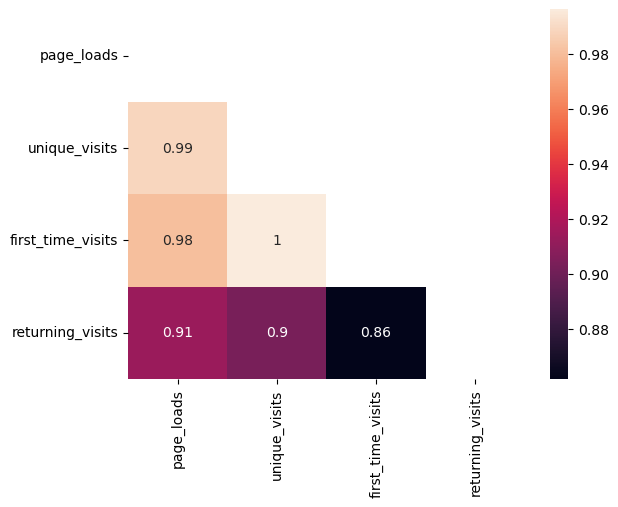

In [17]:
# вариант реализации
mask = np.triu(np.ones_like(df[series_cols].corr(), dtype=bool))
sns.heatmap(df[series_cols].corr(), annot=True, mask=mask)
plt.show()

Видим, что данные сильно похожи между собой! Зная один ряд, мы почти наверняка восстановим и другой ряд. 
Значит, не нужно думать о сложных методах, чтобы прогнозировать многомерные ряды.

### Визуализации ряда

Построим подневную кривую и попробуем "на глаз" оценить:

- среднее: если "мысленно" провести линию среднего, какая она - стабильная, растущая, убывающая?
- разброс: как бы вы описали характер разброса данных по этой картинке?
- есть ли какие-то паттерны?

**Задание**

- задайте размер картинки (20, 10)
- нарисуйте линейный график по величине page_loads

In [18]:
# место для кода

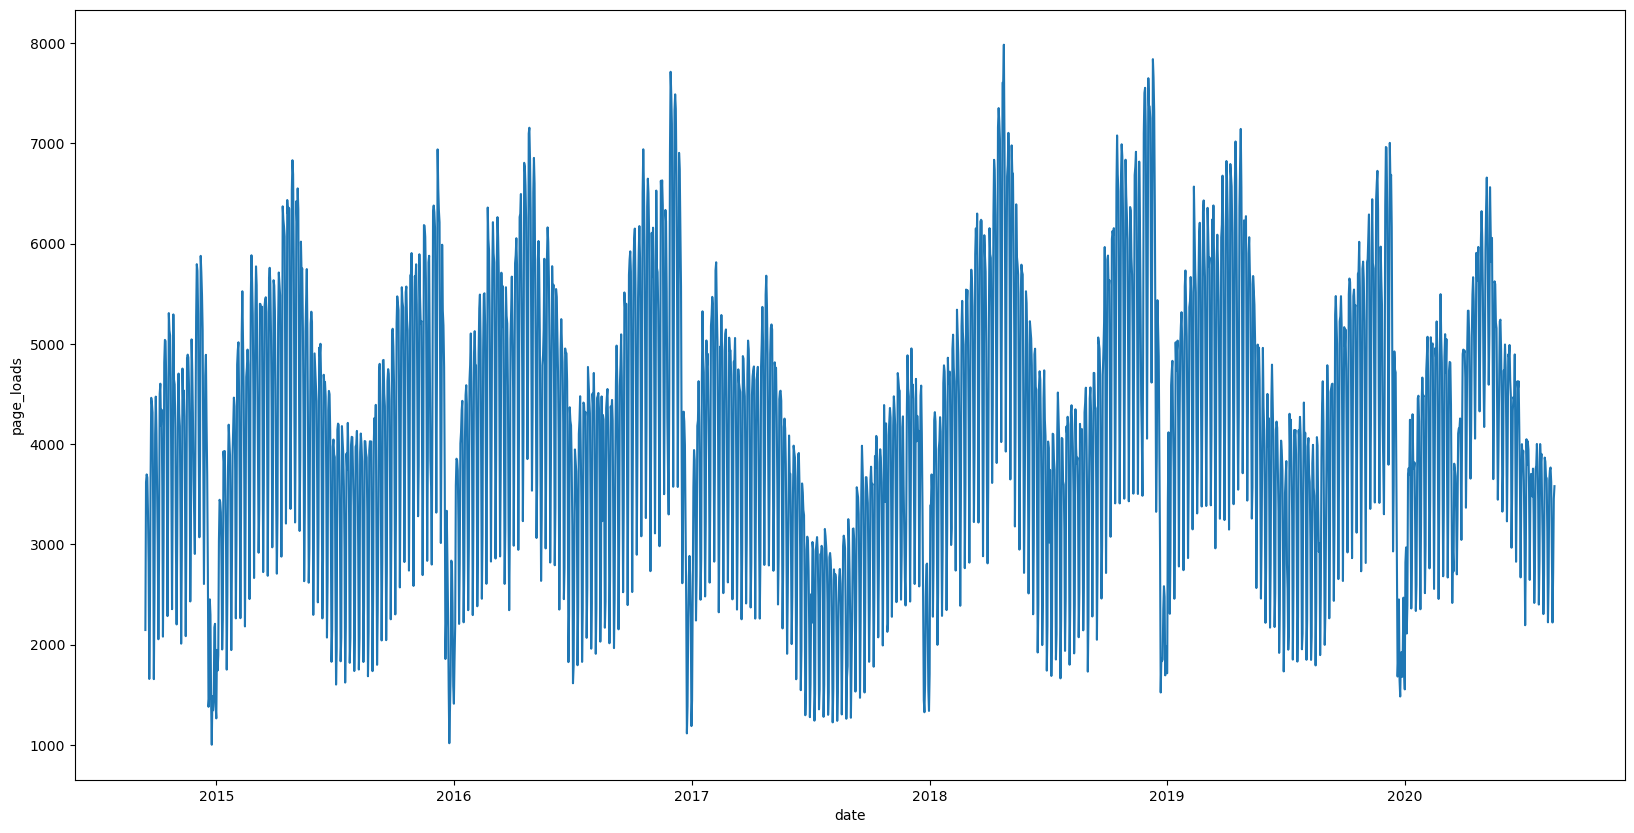

In [19]:
# вариант реализации
plt.figure(figsize=(20, 10))
sns.lineplot(data=df, x='date', y='page_loads')
plt.show()

А если посмотреть на недельные данные? Месячные? Может быть, увидим интересное. Здесь и пригодится трансформация колонки даты - сделаем колонки, по которым сможем посчитать агрегации в нужных срезах.

In [20]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['week'] = df['date'].dt.isocalendar().week 

Вопросы к обсуждению остаются те же. Но при этом данных сразу за год нет, их надо собрать самим. С точки зрения техники совершенно не важно, как агрегируем и за какой временной период - суммируем, считаем среднее или медиану за период - код один и тот же по структуре.


В следующих блоках делаем следующее:
- собираем статистику (сумма, среднее, медиана и т.п.) за нужный период (год, месяц, неделя)
- визуализируем кривую

#### **Годичная агрегация**

Начнем с анализа по годам. Как изменялось среднее ежедневное количество загрузок год от года?

**Задание**

- создайте новый датафрейм yearly_data с двумя колонками year, page_loads
- для создания понадобится метод groupby (для агрегации) и агрегирующая функция mean()

In [21]:
# место для кода

In [22]:
# вариант реализации
yearly_data = df.groupby('year')['page_loads'].mean().reset_index()
yearly_data

year   page_loads
0  2014  3649.926606
1  2015  4082.610959
2  2016  4421.527322
3  2017  3396.175342
4  2018  4500.495890
5  2019  4345.380822
6  2020  4090.168831

**Задание**

- задайте размер картинки (20, 10)
- визуализируйте в виде линейного графика yearly_data
- есть ли интересное на графике?

In [23]:
# место для кода

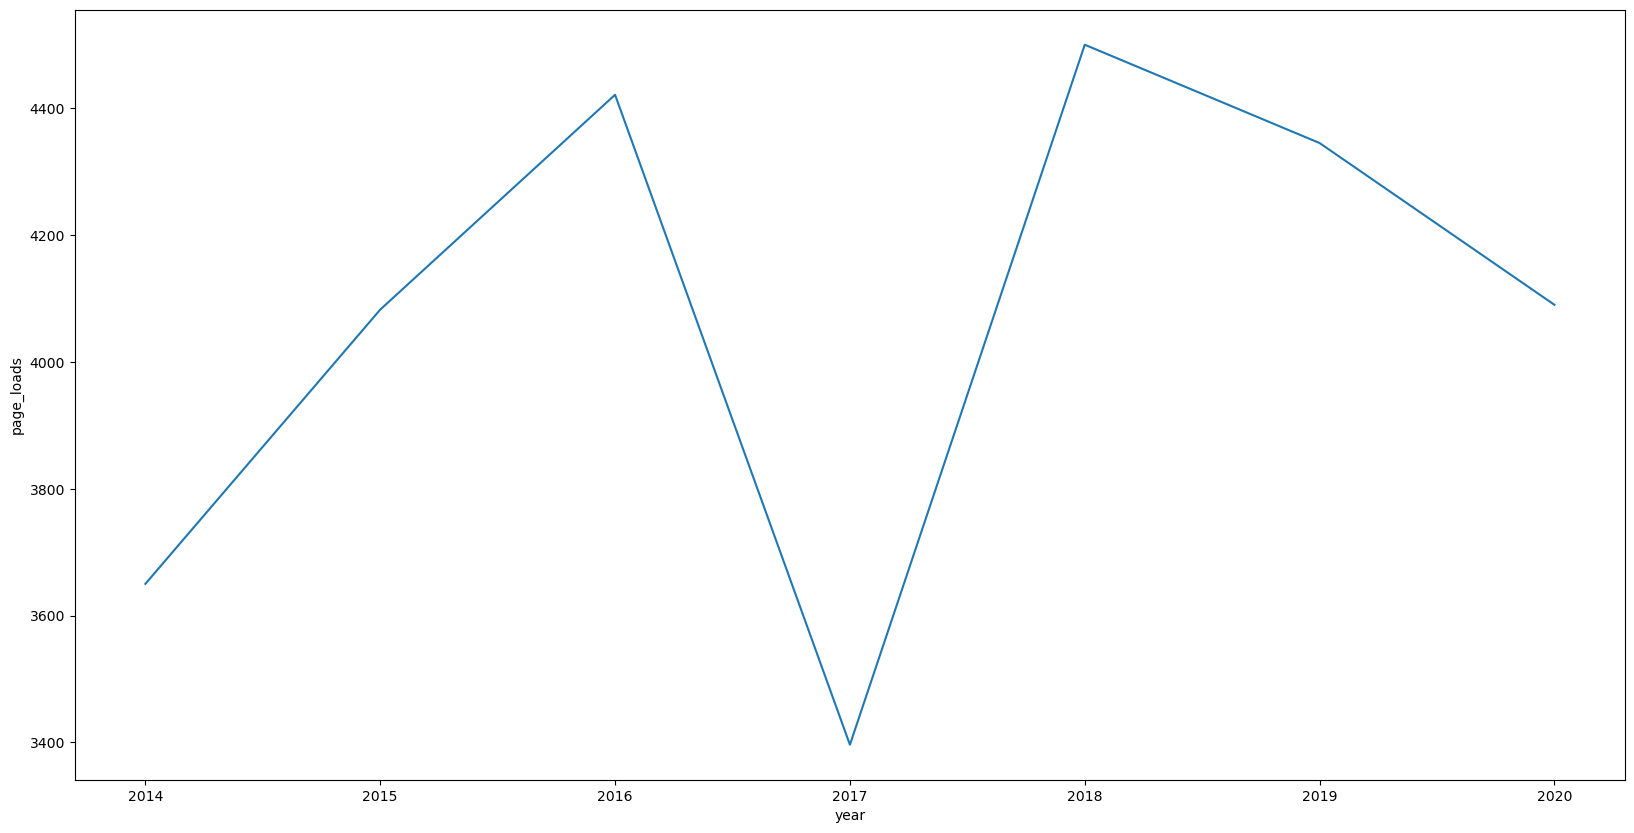

In [24]:
# вариант реализации

plt.figure(figsize=(20, 10))
sns.lineplot(data=yearly_data, x='year', y='page_loads')
plt.show()

#### Месячная агрегация

Теперь смотрим на ежемесячные данные. Обратите внимание, что данные за несколько лет. Агрегация только по месяцу смешает данные за разные годы, поэтому делаем агрегацию по году и месяцу

**Задание**

- создайте новый датафрейм monthly_data с  колонками year, month page_loads
- для создания понадобится метод groupby (для агрегации) и агрегирующая функция mean()

In [25]:
# место для кода

In [26]:
# вариант реализации
monthly_data = df.groupby(['year', 'month'])['page_loads'].mean().reset_index()
monthly_data.head()

year  month   page_loads
0  2014      9  3297.176471
1  2014     10  3934.935484
2  2014     11  3806.333333
3  2014     12  3407.000000
4  2015      1  3099.258065

Конечно же, нам захочется провизуализировать сагрегированные данные, поэтому добавим техническую колонку (объединение месяца и года), чтобы на графике было понятно, за какой год и месяц данные

In [27]:
monthly_data['index'] = monthly_data['year'].astype(str) + '_' + monthly_data['month'].astype(str)

**Задание**

- задайте размер картинки (20, 10)
- визуализируйте в виде линейного графика monthly_data (ось Х - 'index')
- есть ли интересное на графике?

In [28]:
# место для кода

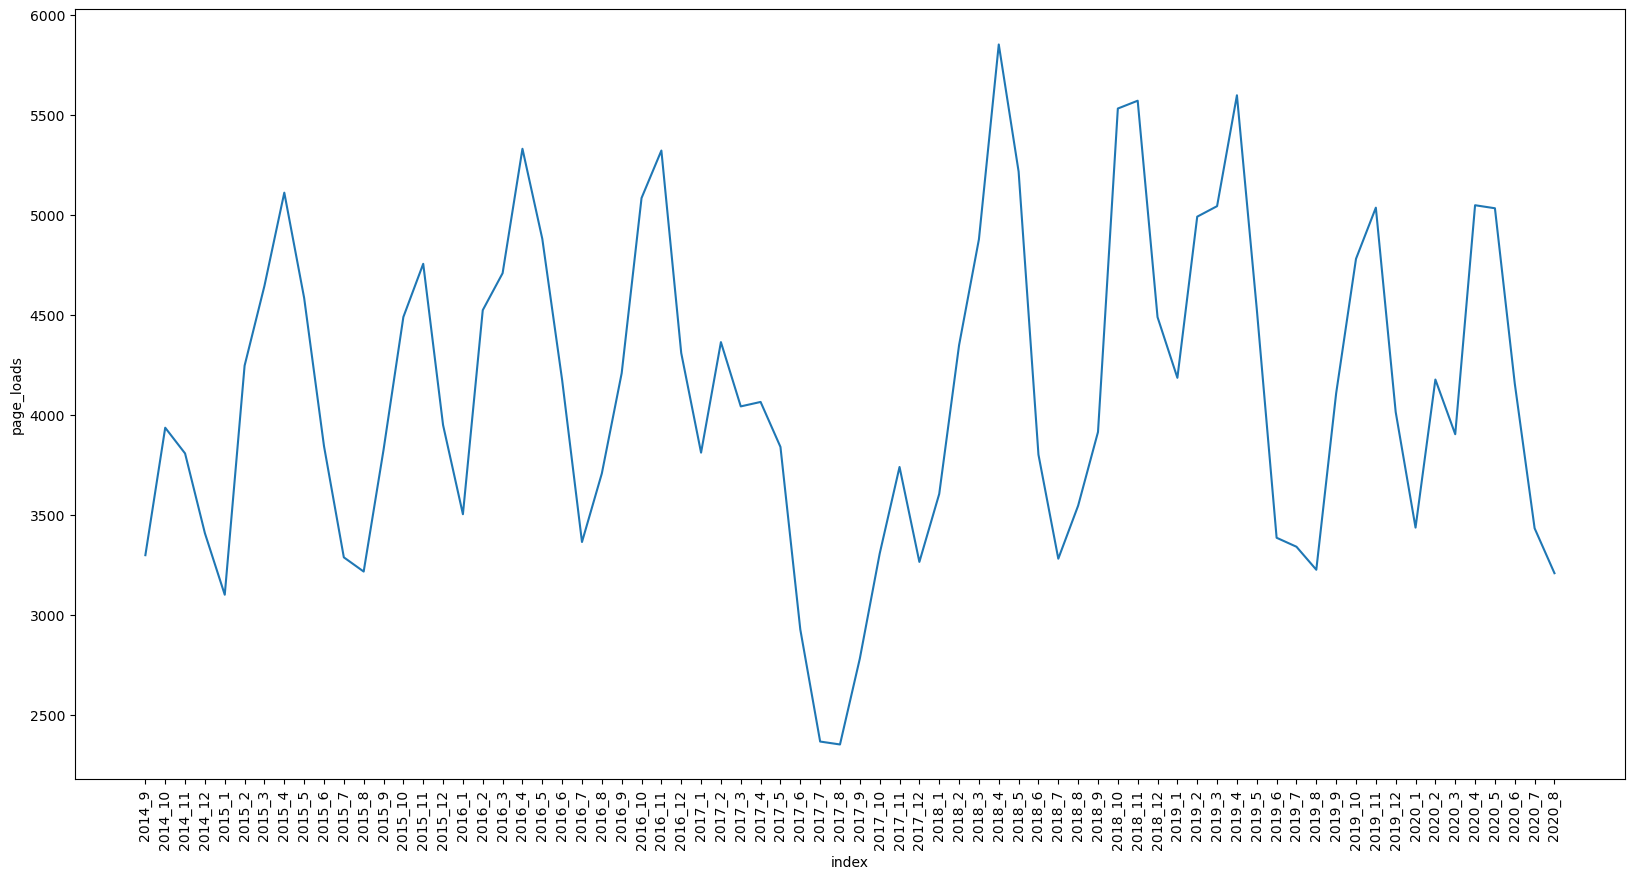

In [29]:
# вариант реализации

plt.figure(figsize=(20, 10))
sns.lineplot(data=monthly_data, x='index', y='page_loads')
plt.xticks(rotation=90)
plt.show()

#### Недельная агрегация

И теперь посмотрим, есть ли что-то интересное на уровне еженедельных агрегаций.

**Задание**

- создайте новый датафрейм weekly_data с  колонками year, week,  page_loads
- для создания понадобится метод groupby (для агрегации) и агрегирующая функция mean()

In [30]:
# место для кода

In [31]:
# вариант реализации
weekly_data = df.groupby(['year', 'week'])['page_loads'].mean().reset_index()
weekly_data.head()

year  week   page_loads
0  2014     1  1920.666667
1  2014    37  2146.000000
2  2014    38  3009.000000
3  2014    39  3467.571429
4  2014    40  3444.857143

Из тех же соображений, что и раньше, добавим техническую колонку:

In [32]:
weekly_data['index'] = weekly_data['year'].astype(str) + '_' + weekly_data['week'].astype(str)

**Задание**

- задайте размер картинки (30, 10)
- визуализируйте в виде линейного графика weekly_data (ось Х - 'index')
- есть ли интересное на графике?

In [33]:
# место для кода

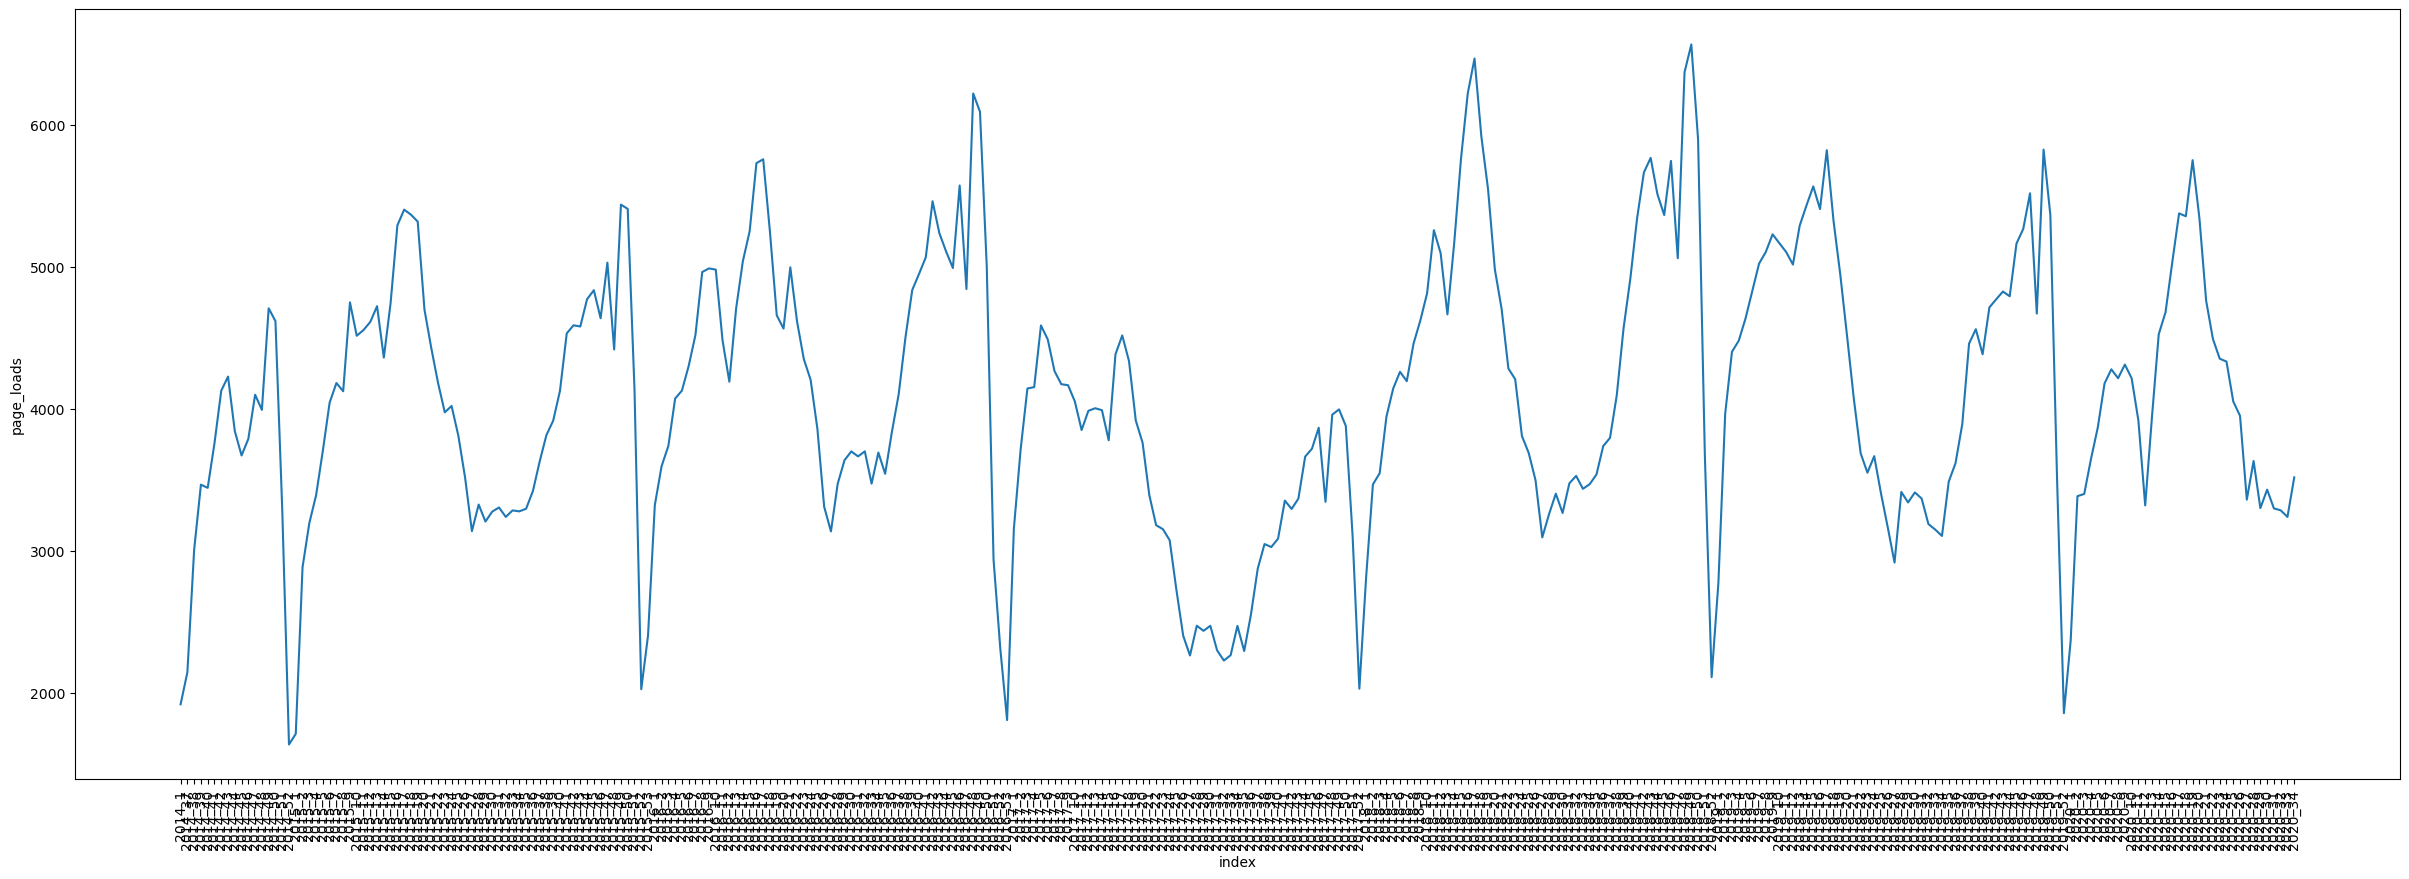

In [34]:
# вариант реализации
plt.figure(figsize=(30, 10))
sns.lineplot(data=weekly_data, x='index', y='page_loads')
plt.xticks(rotation=90)
plt.show()

#### Поиск сезонности

Мы нарисовали графики так, что сразу визуализировали весь временной ряд - данные за 5 лет.
Было бы здорово увидеть, есть ли какая-то сезонность:
- например, больше ли трафик по средам, чем по субботам?
- есть ли какие-то недели, когда регулярно много посетителей?
- бывает ли наплыв в какие-то месяцы?

**Задание**

- вооружимся функцией sns.lineplot и ее параметром hue
- построим зависимость загрузок страницы от дня недели по годам
- построим зависимость загрузок страницы от недели по годам
- построим зависимость загрузок страницы от месяца по годам

In [35]:
# место для кода

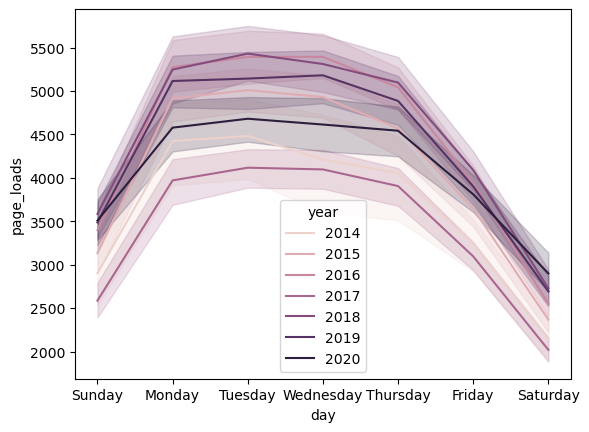

In [36]:
# вариант реализации
# зависимость от дня недели

sns.lineplot(data=df, x='day', y='page_loads', hue='year')
plt.show()

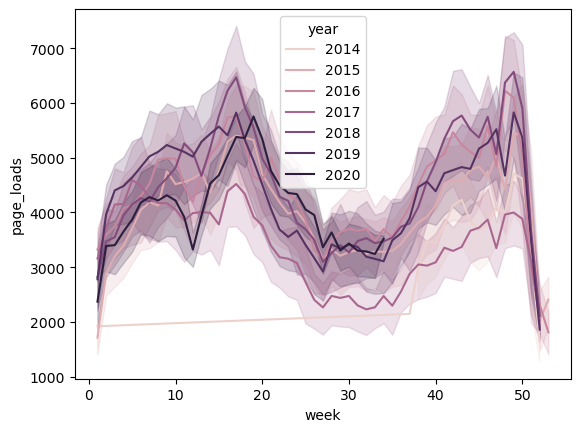

In [37]:
# вариант реализации
# зависимость от недели

df['week'] = df['week'].astype(int)
sns.lineplot(data=df, x='week', y='page_loads', hue='year')
plt.show()

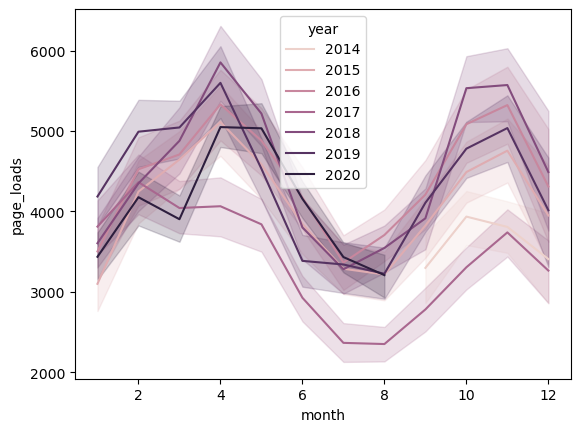

In [38]:
# вариант реализации
# зависимость от месяца

sns.lineplot(data=df, x='month', y='page_loads', hue='year')
plt.show()

### Скользящее среднее

Чуть выше мы занимались прямым применением силы - из своих гипотез конфигурировали данные и визуализировали. Нашли много интересного!

Добавим в наш арсенал еще один инструмент - скользящее среднее!

$$ MA_t = \frac{1}{k} \sum_{i=1}^{k} Y_{t-i+1}$$


- $MA_t$ - значение скользящего среднего в момент времени 
- $Y_t$ - значение временного ряда в момент времени $t$,
- $k$ - размер окна (или периода) скользящего среднего.

Скользящее среднее:
- сгладит шум
- выделит тренд
- выявит цикличность и сезонность
- поможет оценить средний уровень временного ряда

В библиотеке pandas есть метод dataframe.rolling(window=k), который очень легко считает скользящие средние по заданному окну.

В примере ниже задано четырехдневное окно, а также визуализировано скользящее среднее.
Видно ли что-то интересное?

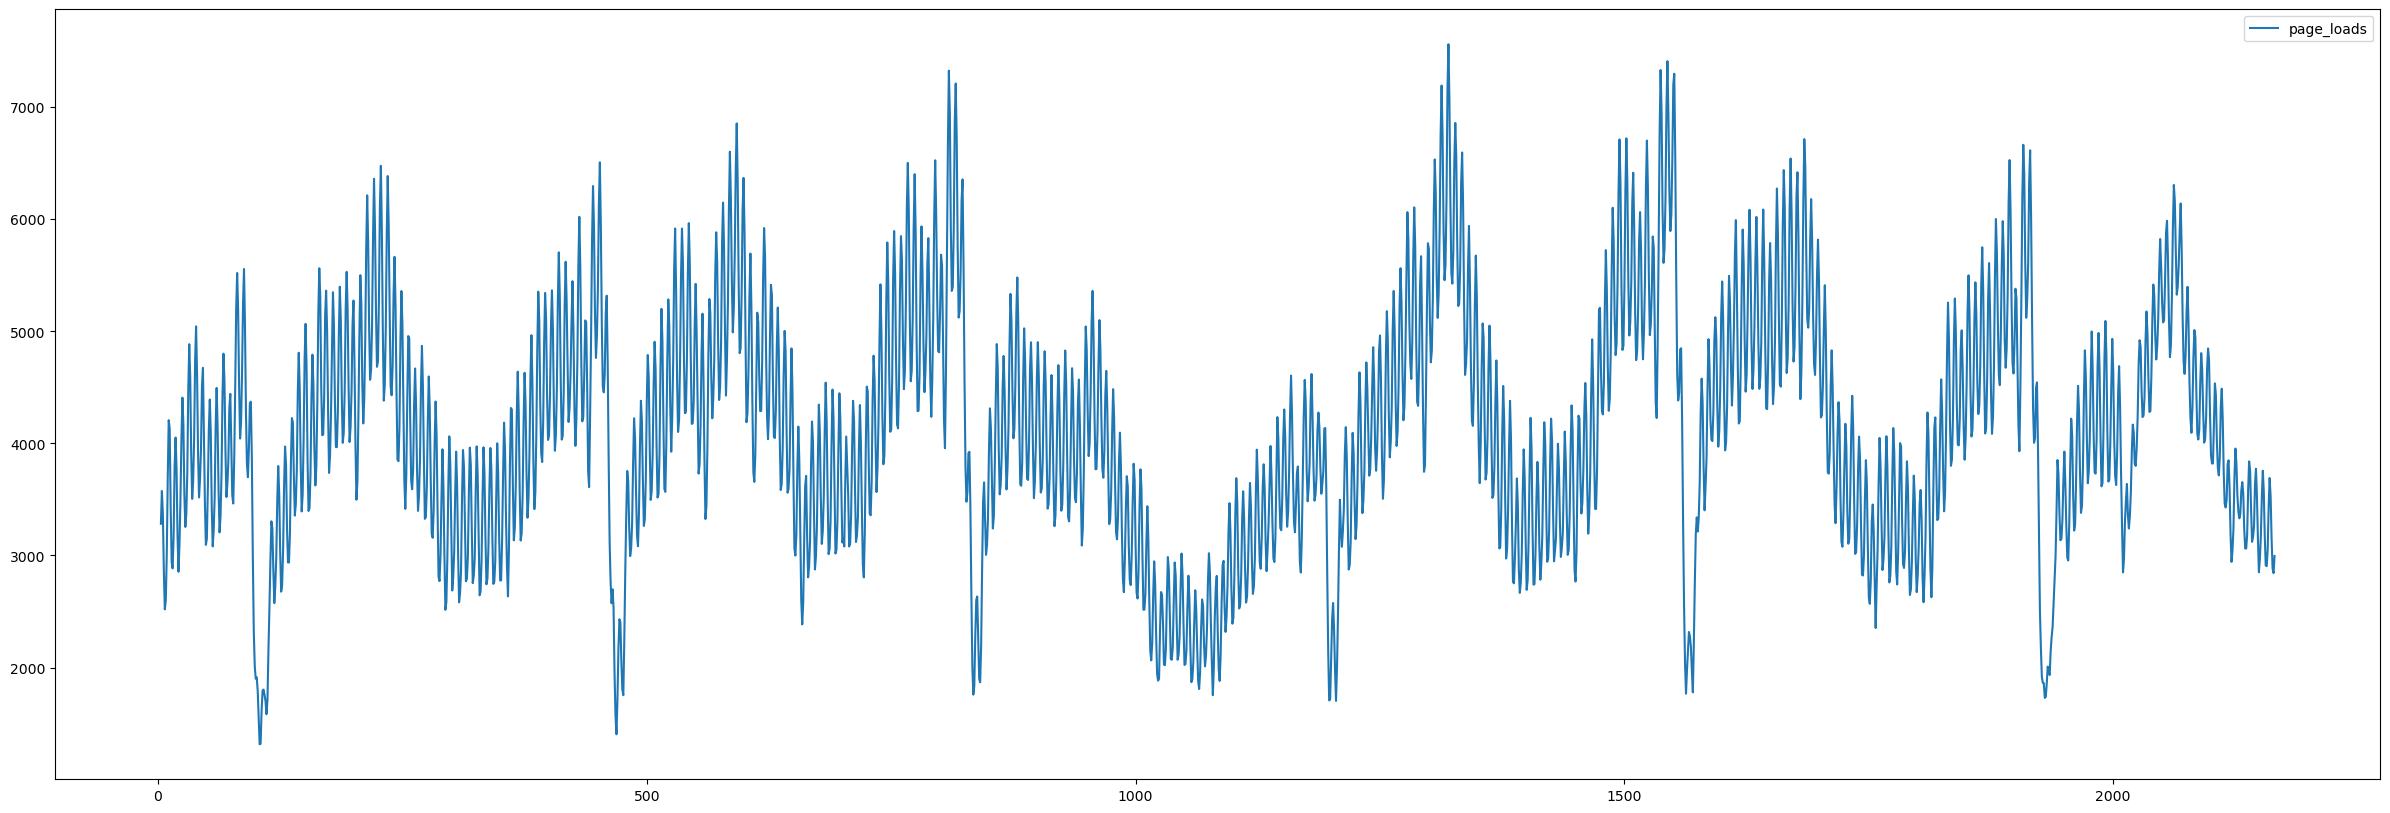

In [39]:
moving_avg = df.drop(['date', 'day'], axis=1).rolling(window = 4).mean()[['page_loads']]
plt.figure(figsize=(30, 10))
sns.lineplot(moving_avg)
plt.show()

**Задание**

- протестируйте 2-3 разных размера окна
- какие выводы можно сделать из новых картинок?

In [40]:
# место для кода

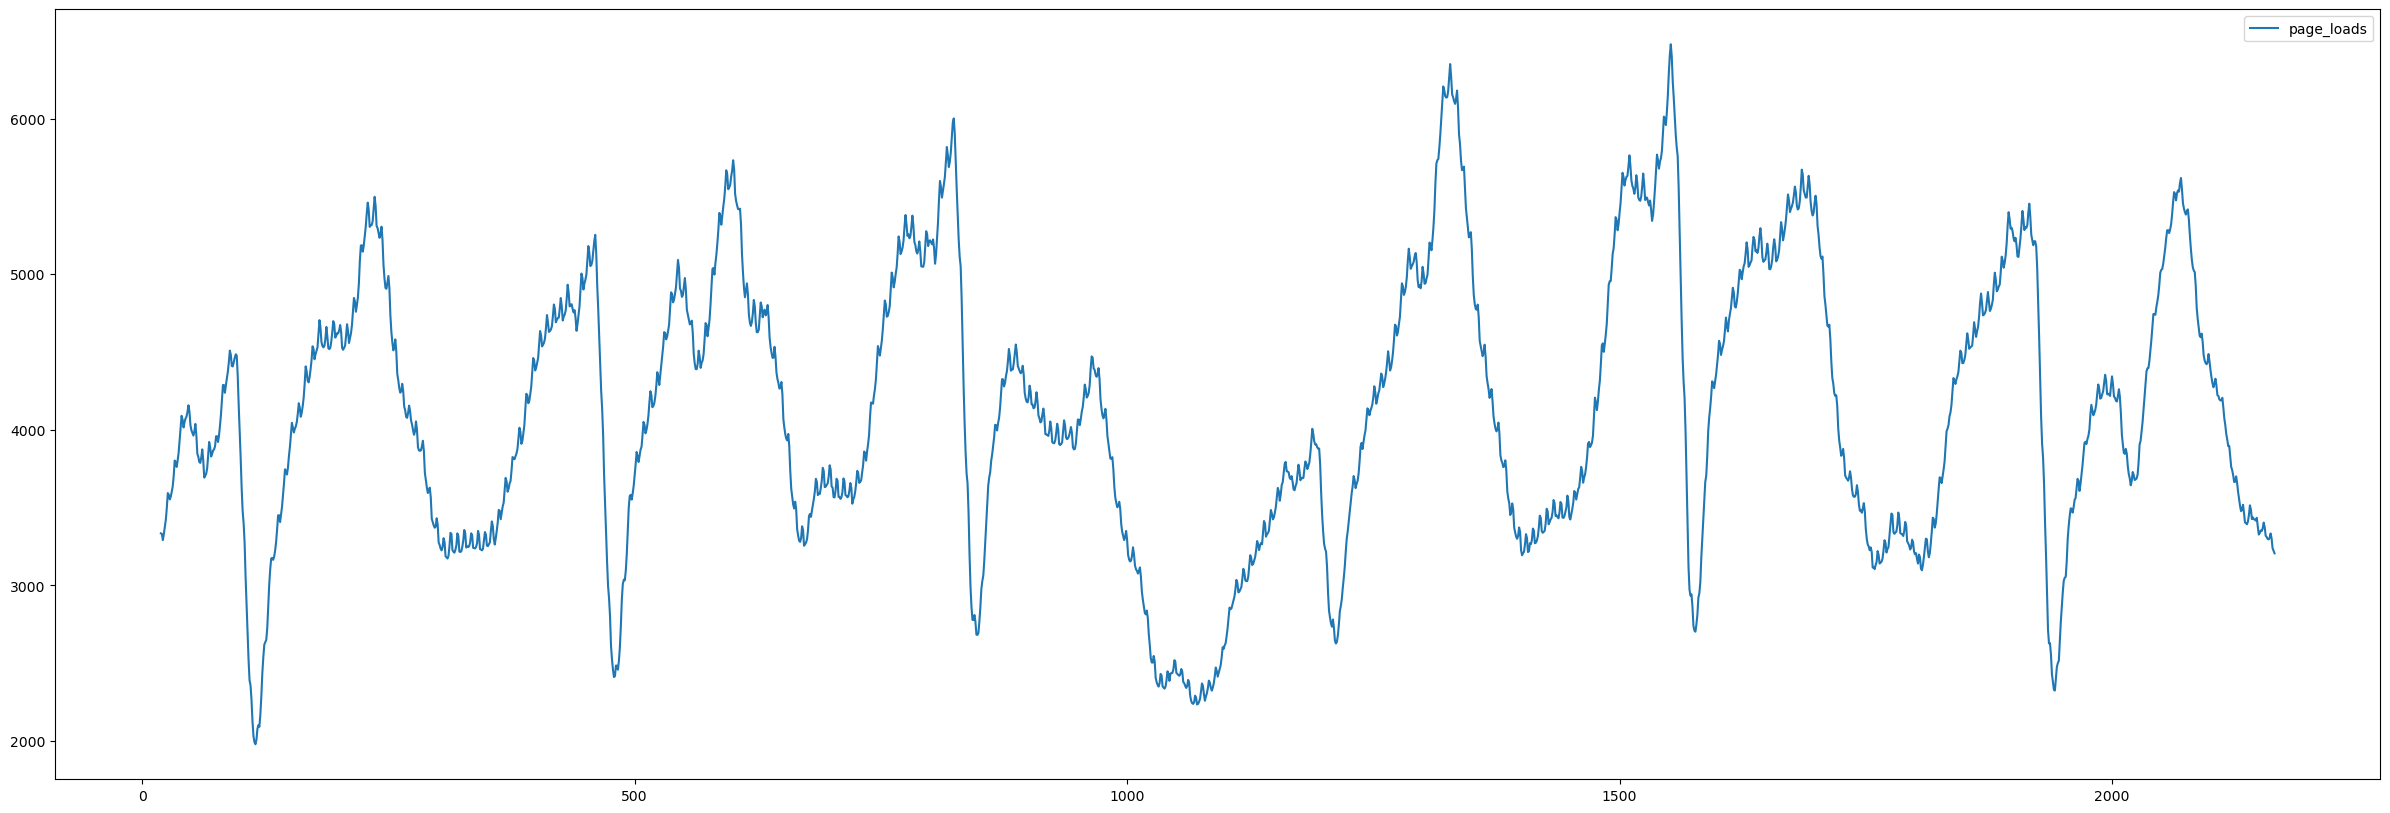

In [41]:
# варианты реализации
moving_avg = df.drop(['date', 'day'], axis=1).rolling(window = 20).mean()[['page_loads']]
plt.figure(figsize=(30, 10))
sns.lineplot(moving_avg)
plt.show()

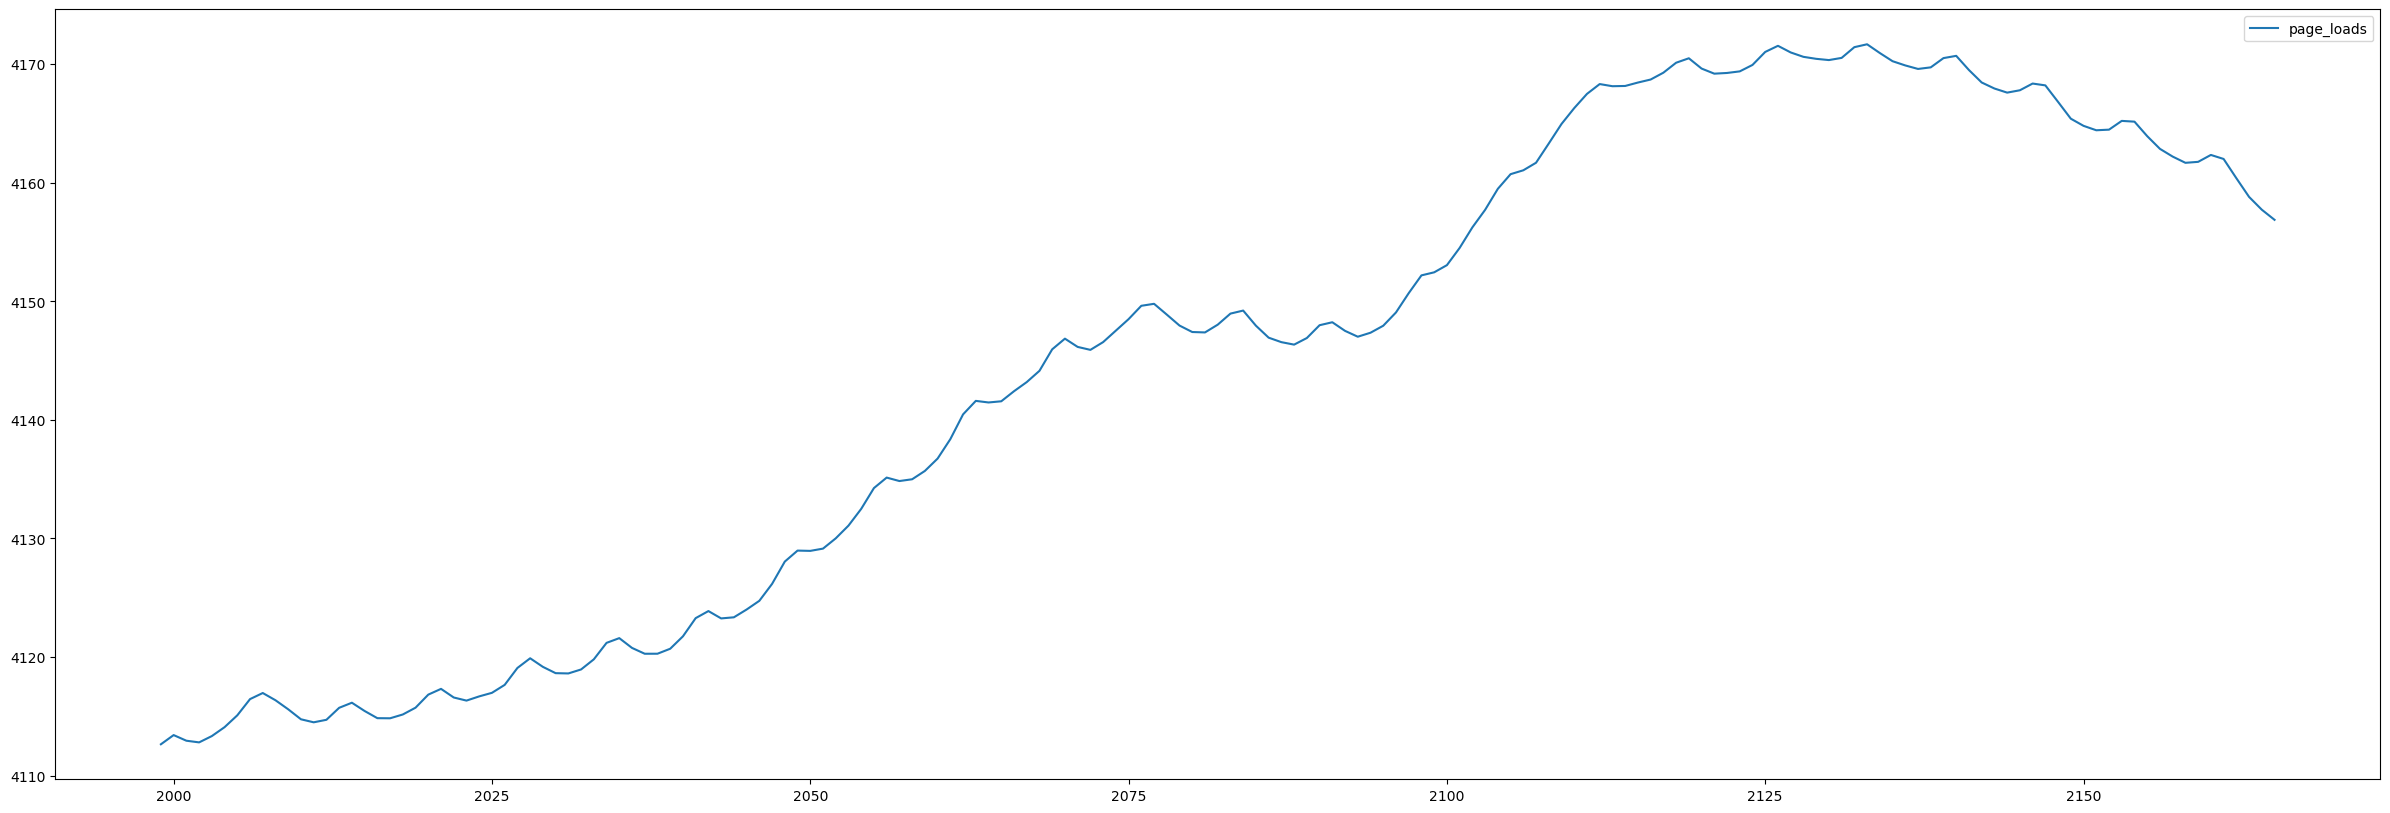

In [42]:
# вариант реализации
moving_avg = df.drop(['date', 'day'], axis=1).rolling(window = 2000).mean()[['page_loads']]
plt.figure(figsize=(30, 10))
sns.lineplot(moving_avg)
plt.show()

## 5. Анализ компонент

Мы обсуждали, что есть два концептуальных подхода к прогнозированию временных рядов:

- разложение ряда на компоненты, прогнозы получаем через знание о следующих значениях компонент;
- обучение регрессии по временному ряду.

В этой секции мы фокусируемся на разложении ряда на компоненты.<br>
Обычно выделяют три компонента:

- **Тренд, $T_t$** — долгосрочное изменение уровня ряда
- **Сезонность, $S_t$** предполагает циклические изменения уровня ряда с постоянным периодом
- **Случайные колебания, $U_t$** — непрогнозируемое случайное изменение ряда

При этом все определения - неформальные, они не дают ответа, как оценить тренд или сезонность.
Формальные определения зависят от моделей, которые мы используем.

Мы предполагаем, что ряд образуется за счет этих трех компонент. 
Есть два подхода к "объединению" компонент:

- $T_t + S_t + U_t$, все сложить, и тогда модель называется **аддитивной**
- $T_t * S_t * U_t$, все умножить, и тогда модель называется **мультипликативной**

Небольшой трюк позволяет получить из мультипликативной модели аддитивную. Поэтому весь фокус на аддитивных моделях.
Отсюда и далее мы верим, что 

$$ ряд = тренд + сезонность + ошибки $$
$$Y_t - T_t + S_t + U_t$$


Идея в том, что зная, как формируются тренд и сезонность, мы можем прогнозировать будущие значения ряда - с поправкой на случайную ошибку.

### Самописная модель

Раз формального определения нет, то ничто не мешает самостоятельно определить модель. <br> Например, мне хочется считать, что тренда нет, это почти прямая кривая с какими-то небольшими колебаниями - авторская модель. В норме нужно предложить какую-то аргументацию, почему так должно все моделироваться. Поскольку цель - не написать новую главу в эконометрике, а показать, как работают более сложные модели, аргументация вырезана цензурой :) <br>


Создам последовательность точек и визуализирую ее на графике:

In [43]:
my_trend = np.random.normal(df['page_loads'].mean(), 6, df['page_loads'].count())
my_trend = pd.Series(my_trend, index=df['date'])

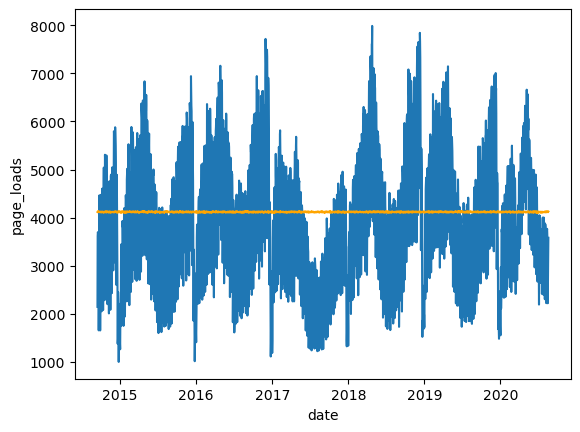

In [44]:
sns.lineplot(data=df, x='date', y='page_loads')
sns.lineplot(data=my_trend, x='date', y=my_trend, color='orange')
plt.show()

Тренд есть. Теперь дело за сезонностью. Методом пристального взгляда кажется, что сезонность может быть описана какой-нибудь синусоидой.

In [45]:
# для y=sin(X) нужны Х:
points = np.arange(df['page_loads'].count())
# а здесь считаем условные Y
# немножко используем знания, как адаптировать синусоиду под себя
# через амплитуду, частоту, фазу, сдвиг по оси Y
my_seasonality = df['page_loads'].std() * np.sin(2 * np.pi * 13 * points / df['page_loads'].count()) + 4000
my_seasonality = pd.Series(my_seasonality, index=df['date'])

Визуализируем всю красоту!

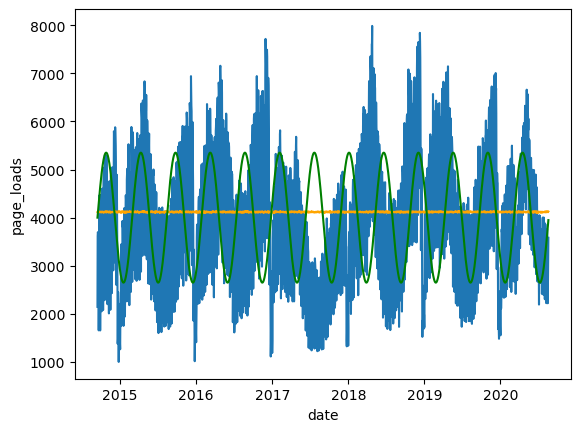

In [46]:
sns.lineplot(data=df, x='date', y='page_loads')
sns.lineplot(data=my_trend, x='date', y=my_trend, color='orange')
sns.lineplot(data=my_seasonality, x='date', y=my_seasonality, color='green')

plt.show()

Посчитаем и нарисуем ошибки

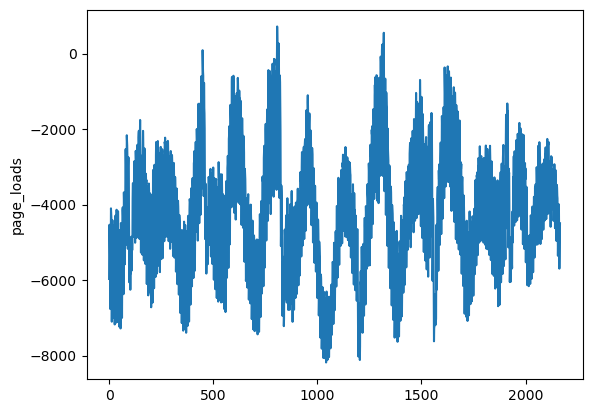

In [47]:
my_residuals = df['page_loads'] - my_trend.values - my_seasonality.values
sns.lineplot(my_residuals)

plt.show()

Хорошим знаком считаются случайно распределенные ошибки, а картинка сверху не выглядит случайной.
В целом, визуальный анализ трех компонент выглядит неудачным.

Попытка придумать модели имени себя не увенчалась успехом. Посмотрим, что предлагается в других библиотеках.

### Использование готовых функций

Существует немало библиотек для работы с временными рядами. Мы воспользуемся statsmodels и парочкой ее функций.

В этой части нужна:
- **from statsmodels.tsa.seasonal import seasonal_decompose**

Мы ее загружали в начале тетрадки, поэтому повторно здесь не загружаем.

Что делает эта функция? Раскладывает временной ряд на компоненты. <br>
Иными словами, то же, что и мы в секции выше: 
- пытается из одного ряда получить тренд, сезонность и случайне ошибки.

Как?

- тренд оценивается скользящим средним: т.е. буквально ряд сглаживается, чтобы проявился "тренд"
- сезонная компонента находится чуть сложнее:
    - от исследователя ждут задания периодичности -- размера окна сезонности 
    - детрендируется ряд: буквально из исходного ряда удаляется насчитанный ряд тренда
    - для каждого периода считается среднее детрендированного ряда
    - все, что не попало в тренд или в сезонность, называется необъясняемой ошибкой 


Давайте посмотрим, как разложит наш ряд этот подход.

Для начала сделаем небольшую трансформацию - колонку даты сделаем индексом исходной таблицы.
Этот трюк нужен, если мы доверимся самой функции и дадим ей возможность оценить периодичность.

In [48]:
tdi = pd.DatetimeIndex(df.date)
df.set_index(tdi, inplace=True)

И тут же задействуем ее! Созданную декомпозицию легко визуализировать встроенными инструментами.

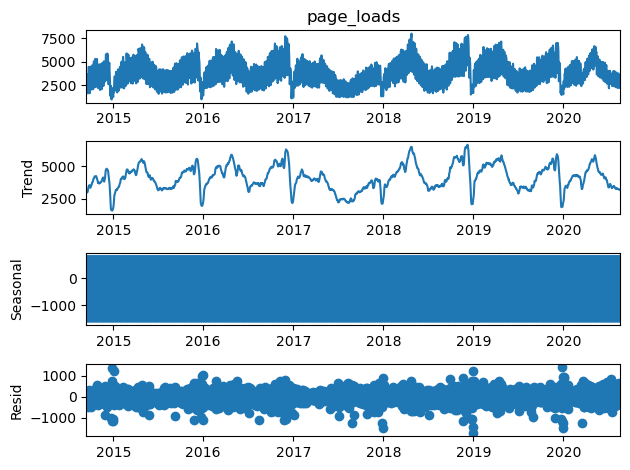

In [49]:
decompose = seasonal_decompose(x=df['page_loads'])
decompose.plot()

plt.show()

Попробуем задать периодичность самостоятельно - например, что есть годичная сезонность.

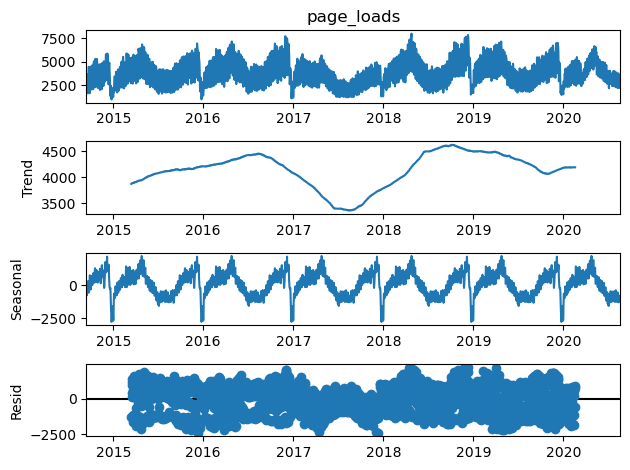

In [50]:
decompose = seasonal_decompose(x=df['page_loads'], period=365)
decompose.plot()

plt.show()

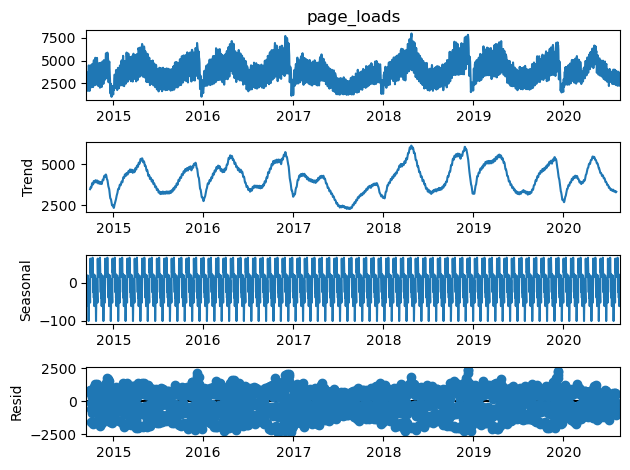

In [51]:
decompose = seasonal_decompose(x=df['page_loads'], period=30)
decompose.plot()

plt.show()

## Моделирование

Вернемся к основному вопросу практики - как делать прогнозы временного ряда. Прежде чем приступить к моделированию, обсудим два вопроса: какой метрикой измерить качество любой модели и как валидировать модели. 

### Метрики качества

Все примеры рядов, которые приведены в начале тетрадки - численные наблюдения, т.е. работаем с задачей регрессии. Поэтому вспомним основные метрики регресии:

 **MAE (mean absolute error)**, средняя абсолютная ошибка. Она вычисляется следующим образом: 

$$ MAE = \frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y}_i|. $$

Если мы спрогнозировали, что будет 20 посетителей, а на самом деле 10, мы ошиблись на |10 - 20| = 10 посетителей. Средняя абсолютная ошибка - это среднее кол-во пользователей, на которые мы ошиблись. 

**MSE (mean squared error)**, средняя квадратичная ошибка. Она вычисляется как 

$$ MSE = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2.$$

Смысл этой ошибки в том, чтобы штрафовать за большие ошибки сильнее, чем за маленькие. Если мы ошиблись на 5 визитов, то в ошибку войдёт 25. Если мы ошиблись на 10 визитов, то в ошибку войдёт 100. Чем выше ошибка, тем сильнее штраф. 

$$ RMSE = MSE ** 1 /2 $$


Часто для нас принципиальным является не то, на сколько мы ошиблись, а то на сколько процентов мы ошиблись. Метрика, которая отлавливает процентную ошибку, называется **MAPE (mean absolute percentage error)**, средняя абсолютная процентная ошибка. 

$$
MAPE = \frac{1}{n} \sum_{i=1}^n \frac{|y_i - \hat{y}_i|}{y_i}
$$

Она часто применяется в следующих задачах: например, вы прогнозируете спрос, и вам принципиально, на сколько процентов вы ошиблись, а не абсолютное значение. Если вы предсказали  один, а в реальности было  десять - это не то же самое, что вы предсказали  тысяча, а в реальности было  тысяча  девять. С точки зрения МАЕ или MSE, это две совершенно одинаковые ошибки. А если вас интересует, сколько в среднем на сколько процентов вы ошибаетесь, то это отражает МАРЕ.


Качество построенной модели измеряется **коэффициентом детерминации**
$R^2$. Он отражает то, какую долю дисперсии объясняемой переменной мы объяснили с помощью нашей модели:

$$ R^2 =1- \frac{ \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{ \frac{1}{n}\sum_{i=1}^{n} (y_i - \bar{y}_i)^2} $$


Для задачи можно считать все; предложим следить за одной абсолютной метрикой и за одной относительной, например, за $MAE$ и $R^2$. Считающие их функции загружены в самом начале тетрадки

### Разбиение на train - test

На лекции обсуждали различные **стратегии валидации**.:

- отложенная выборка
- к-блочная кросс-валидация
- валидация растущим окном
- валидация скользящим окном

Для простоты мы используем аналог отложенной выборки по временным рядам - разделение на тренировочную и тестовую части по дате: до даты Х все данные - тренировочные, после - тестовые.

Дату можно выбрать любую.

**Задание**

- разбейте данные на две части: train_data, test_data
- оставьте в ней инфо о дате и колонку page_loads
- дата разбиения, переменная division_date = '2020-08-01'

In [52]:
# место для кода

In [53]:
# вариант реализации
division_date = '2020-08-01'
train_data = df[df.index < division_date]['page_loads']
test_data = df[df.index >= division_date]['page_loads']

Иллюстрируем разбиение: 

**Задание**

- на одном графике визуализируйте разбиение на тестовую и тренировочные выборки
- тестовые данные - красным цветом, а тренировочные - синим

In [54]:
# место для кода

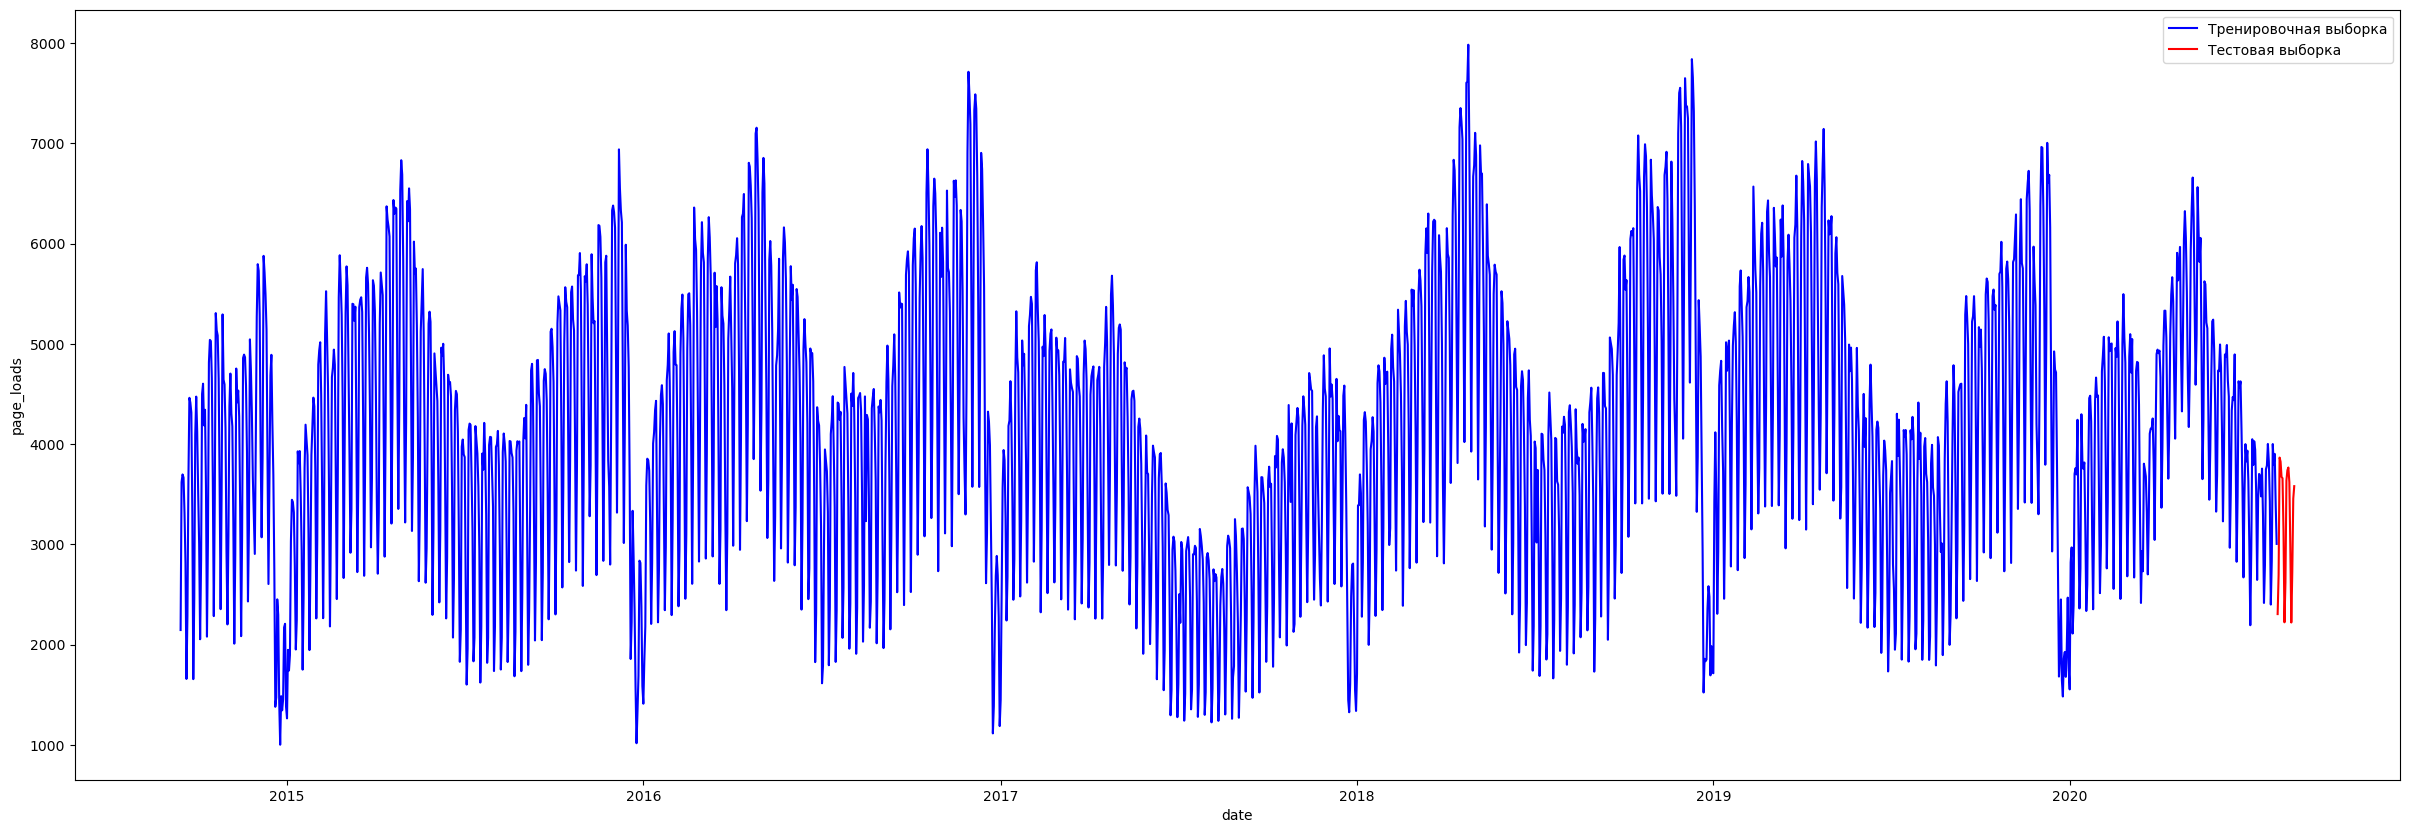

In [55]:
# вариант реализации

plt.figure(figsize=(30, 10))
sns.lineplot(train_data, color = "blue", label='Тренировочная выборка')
sns.lineplot(test_data, color = "red", label='Тестовая выборка')
plt.show()

### Наивный прогноз_1

До работы со моделями разной степени сложности посмотрим, какое качество обеспечат наивные прогнозы.
Первый вариант - делать прогнозы по среднему.

**Задание**

- создайте массив из средних значений тренировочной выборки; размер массива совпадает с размером тестовой выборки
- созданный массив должен быть pd.Series, а индексы - даты тестовой выборки

In [56]:
# место для кода

In [57]:
# вариант реализации
mean_value = train_data.mean()
naive_preds = [mean_value]*len(test_data)
naive_preds = pd.Series(naive_preds, index=test_data.index)

**Задание**

- на одном графике визуализируйте истинные значения тестовой выборки красным цветом и значения прогнозов, полученных из предыдущего задания, зеленым цветом
- создайте легенду

In [58]:
# место для кода

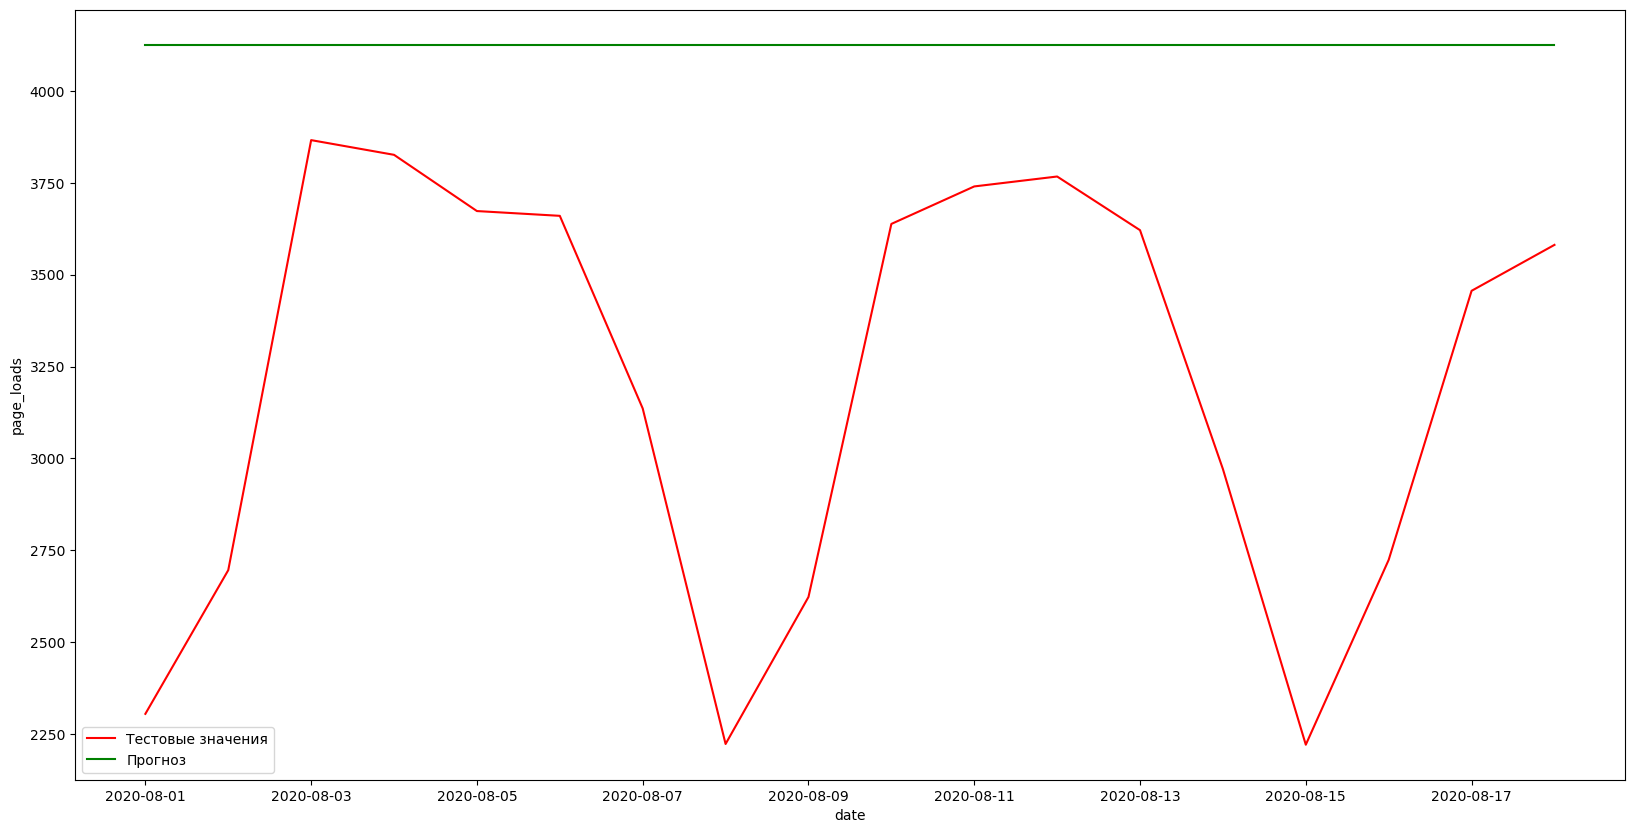

In [59]:
# вариант реализации

plt.figure(figsize=(20, 10))
sns.lineplot(test_data, color = "red", label='Тестовые значения')
sns.lineplot(naive_preds, color = "green", label='Прогноз')

plt.show()

**Задание**

- рассчитайте MAE и $R_2$ для сделанных прогнозов
- как вы оцениваете качество модели?

In [60]:
# место для кода

In [61]:
# вариант реализации
print('MAE прогноза:', mae(test_data, naive_preds))
print('R2 модели:', r2_score(test_data, naive_preds))

MAE прогноза: 918.5147423960271
R2 модели: -2.5114235200703456


Что уж скрывать, до совершенства определенно есть расстояние! Это видно и визуально, и на метриках прогноза.

### Наивный прогноз_2

Другой вариант базового прогноза - прогнозировать последним известным значением, т.е.
$\hat{y}_{t+1} = y_{t}$

Если делать прогноз на несколько периодов вперед по этому правилу, то получится константный прогноз из известного последнего значения.

**Задание**

- создайте массив из последнего значения тренировочной выборки; размер массива совпадает с размером тестовой выборки
- созданный массив должен быть pd.Series, а индексы - даты тестовой выборки

In [62]:
# место для кода

In [63]:
# вариант реализации
naive_preds_2 = [train_data[-1]]
for i in range(1, len(test_data)):
    naive_preds_2.append(naive_preds_2[i-1])
    
naive_preds_2 = pd.Series(naive_preds_2, index=test_data.index)

**Задание**

- на одном графике визуализируйте истинные значения тестовой выборки красным цветом и значения прогнозов, полученных из предыдущего задания, зеленым цветом
- создайте легенду

In [64]:
# место для кода

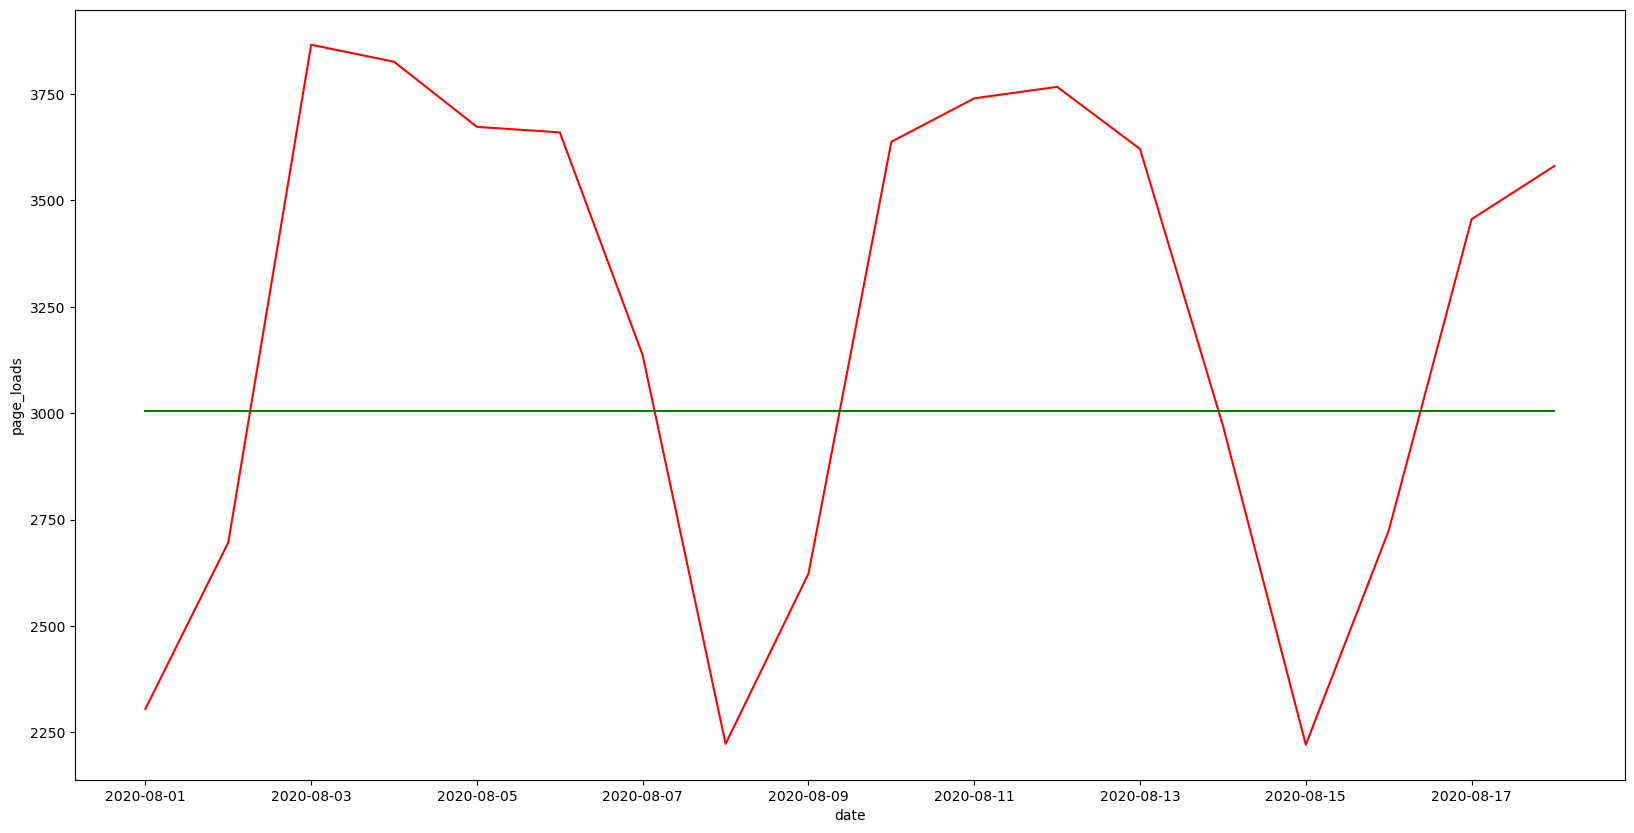

In [65]:
plt.figure(figsize=(20, 10))
sns.lineplot(test_data, color = "red")
sns.lineplot(naive_preds_2, color = "green")

plt.show()

**Задание**

- рассчитайте MAE и $R_2$ для сделанных прогнозов
- как вы оцениваете качество модели?

In [66]:
# место для кода

In [67]:
print('MAE прогноза:', mae(test_data, naive_preds_2))
print('R2 модели:', r2_score(test_data, naive_preds_2))

MAE прогноза: 565.6111111111111
R2 модели: -0.12153161989070749


### Модель Хольта-Винтерса

Чуть-чуть усложнимся и познакомимся с другим семейством моделей.

В модели экспоненциального сглаживания (exponential smoothing) или экспоненциального скользящего среднего берем все предыдущие значения и задаем каждому из наблюдений определенный вес и (экспоненциально) уменьшаем этот вес по мере углубления в прошлое.

$$\hat{y}_{t+1} = \alpha \cdot y_t + (1-\alpha) \cdot \hat{y}_{t}$$

Мы явно видели, что в данных есть сезонность. И, возможно, даже тренд. Поэтому возьмем за основу модель, которая называется ETS(AAA).


**ETS (Error, Trend, Seasonality)** - это семейство моделей временных рядов, которые включают в себя компоненты ошибки, тренда и сезонности. Модель экспоненциального сглаживания с трендом и сезонностью обозначается как ETS(A, A, A), где каждая буква представляет собой компонент модели:

- Ошибка (Error): A - аддитивная, M - мультипликативная.
- Тренд (Trend): A - аддитивный, M - мультипликативный.
- Сезонность (Seasonality): A - аддитивная, M - мультипликативная.

$$y_t = \ell_{t-1} + b_{t-1} + s_{t-m} + \varepsilon_t$$

- $y_t$ - наблюдаемое значение временного ряда в момент времени
- $\ell_{t-1}$ - уровень (уровень тренда) в момент времени $t-1$
- $b_{t-1}$  - тренд в момент времени $t-1$
- $s_{t-m}$ - сезонная компонента в момент времени $t−m$ (где m - длина сезонного периода),
- $ \varepsilon_t$ - ошибка в момент времени t.

Каждый из этих компонентов обновляется на основе предыдущих значений и ошибок, используя экспоненциальное сглаживание. Формулы для обновления этих компонентов могут выглядеть следующим образом:

$$\ell_t = \alpha (y_t - s_{t-m}) + (1 - \alpha)(\ell_{t-1} + b_{t-1}) $$
$$b_t = \beta (\ell_t - \ell_{t-1}) + (1 - \beta)b_{t-1} $$
$$s_t = \gamma (y_t - \ell_{t-1} - b_{t-1}) + (1 - \gamma)s_{t-m}$$

In [68]:
hw_model = ExponentialSmoothing(
    train_data,
    trend="add",
    seasonal="add",
    seasonal_periods=365
)

hw_model_fitted = hw_model.fit(remove_bias=True)

/Users/elentevanyan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/elentevanyan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [69]:
hw_preds = hw_model_fitted.forecast(steps=test_data.shape[0])

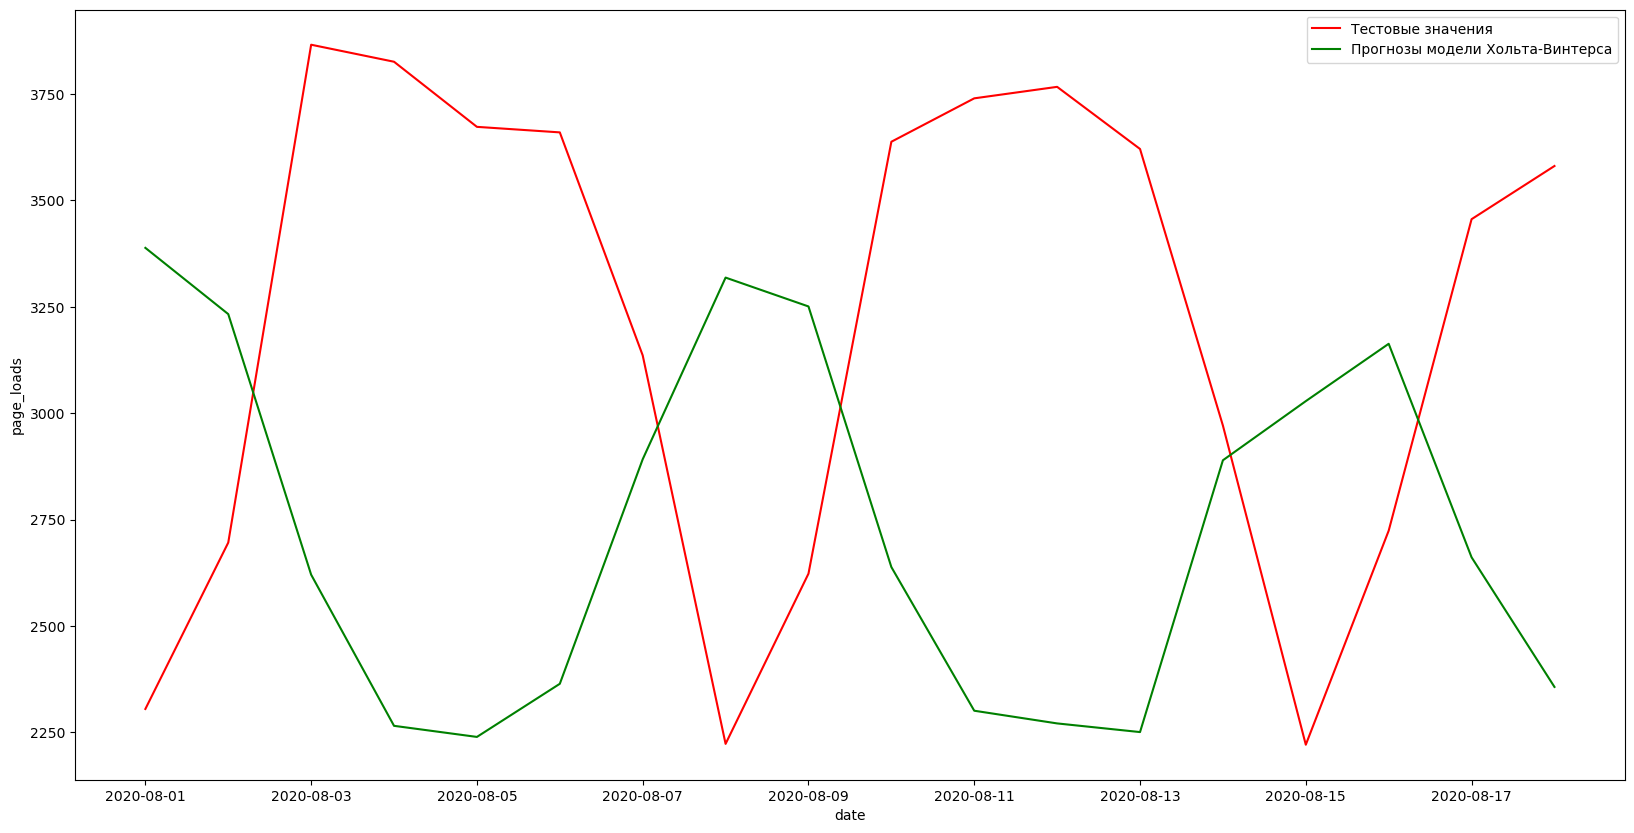

In [70]:
plt.figure(figsize=(20, 10))
sns.lineplot(test_data, color = "red", label='Тестовые значения')
sns.lineplot(hw_preds, color = "green", label='Прогнозы модели Хольта-Винтерса')

plt.show()

**Задание**

- рассчитайте MAE и $R_2$ для сделанных прогнозов
- как вы оцениваете качество модели?

In [71]:
# место для кода

In [72]:
# вариант реализации
print('MAE прогноза:', mae(test_data, hw_preds))
print('R2 модели:', r2_score(test_data, hw_preds))

MAE прогноза: 987.5368725834697
R2 модели: -2.4737789577663896


### Prophet

В основе этой библиотеки - аддитивная модель, которая умеет классно учитывать сезонность по неделе, месяцам и праздникам. Звучит как то, что идеально может нам подойти, поэтому надо пробовать!

Библиотека требует от нас организованности:
- колонка с данными должна называться ds
- колонка с рядом должна называться y
- обе колонки - колонки, т.е. дата не может быть индексом

Нужно все реорганизовать. Посмотрим, как выглядят данные сейчас:

In [73]:
train_data.head()

date
2014-09-14    2146
2014-09-15    3621
2014-09-16    3698
2014-09-17    3667
2014-09-18    3316
Name: page_loads, dtype: int64

Приводим в порядок

In [74]:
train_data_prophet = train_data.reset_index().rename(columns={'date': 'ds', 'page_loads': 'y'})

По структуре обучения код мало отличается от обучения линейной регрессии или случайных лесов.

In [75]:
model_prophet = Prophet()
model_prophet.fit(train_data_prophet)

22:52:42 - cmdstanpy - INFO - Chain [1] start processing
22:52:42 - cmdstanpy - INFO - Chain [1] done processing


А для получения прогнозов библиотека снова требует от нас аккуратности. Надо создать таблицу нужного размера - по количеству периодов, на который нам нужен прогноз, и только затем посчитать прогнозы.

Не то, чтобы у нас нет своей заготовки в виде test_data, но в учебных целях сделаем по инструкции:

In [76]:
prophet_future = model_prophet.make_future_dataframe(periods=len(test_data))
prophet_future.tail()

ds
2161 2020-08-14
2162 2020-08-15
2163 2020-08-16
2164 2020-08-17
2165 2020-08-18

In [77]:
prophet_preds = model_prophet.predict(prophet_future)

Прогнозы получены. Давайте посмотрим, что там есть.

In [78]:
#[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
prophet_preds.head()

ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2014-09-14  3371.898688  1517.225223  2674.751606  3371.898688  3371.898688   
1 2014-09-15  3374.830791  3174.691678  4402.750298  3374.830791  3374.830791   
2 2014-09-16  3377.762893  3293.255568  4509.570559  3377.762893  3377.762893   
3 2014-09-17  3380.694996  3330.709735  4526.476496  3380.694996  3380.694996   
4 2014-09-18  3383.627098  3081.976857  4299.952402  3383.627098  3383.627098   

   additive_terms  additive_terms_lower  additive_terms_upper      weekly  \
0    -1276.932169          -1276.932169          -1276.932169 -871.452402   
1      376.019847            376.019847            376.019847  733.197400   
2      533.714408            533.714408            533.714408  843.154774   
3      523.537400            523.537400            523.537400  786.346555   
4      315.615562            315.615562            315.615562  533.405292   

   weekly_lower  weekly_upper      yearly  yearly_lower  yearly_upper  \
0   -871.452402   -871.452402 -405.479767   -405.479767   -405.479767   
1    733.197400    733.197400 -357.177554   -357.177554   -357.177554   
2    843.154774    843.154774 -309.440366   -309.440366   -309.440366   
3    786.346555    786.346555 -262.809155   -262.809155   -262.809155   
4    533.405292    533.405292 -217.789730   -217.789730   -217.789730   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper         yhat  
0                         0.0  2094.966519  
1                         0.0  3750.850637  
2                         0.0  3911.477301  
3                         0.0  3904.232396  
4                         0.0  3699.242660

В таблице довольно много колонок, все - результат моделирования и прогноза.
- **df** - дата
- **yhat** - значение прогноза
- **yhat_lower** и **yhat_upper** - верхняя и нижняя граница предиктивного интервала

Остальные колонки - раскладка тренда и разных видов сезонностей.

Чтобы посчитать качество прогноза, достаточно забрать $yhat$

In [79]:
prophet_preds_value = prophet_preds[prophet_preds['ds'] >=division_date]['yhat']

In [80]:
print('MAE прогноза:', mae(test_data, prophet_preds_value))
print('R2 модели:', r2_score(test_data, prophet_preds_value))

MAE прогноза: 335.9560756980449
R2 модели: 0.5366101095104281


Сначала нарисуем графики самостоятельно!

In [81]:
prophet_preds_value.index = test_data.index

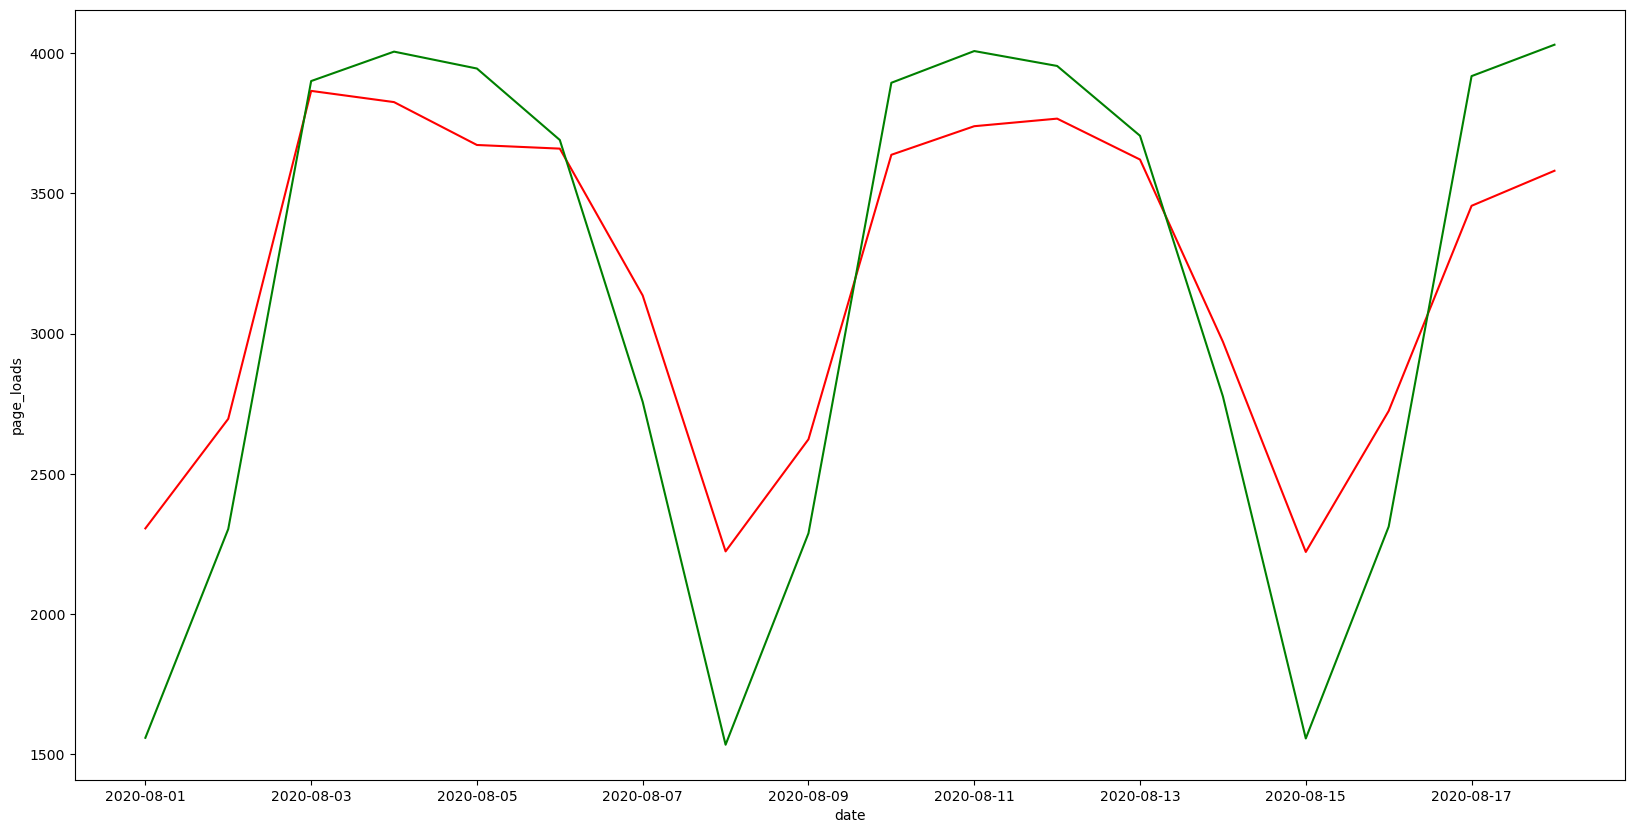

In [82]:
plt.figure(figsize=(20, 10))
sns.lineplot(test_data, color = "red")
sns.lineplot(pd.Series(prophet_preds_value), color = "green")

plt.show()

Конечно же, как продвинутая библиотека, prophet предоставляет свои функции визуализации:

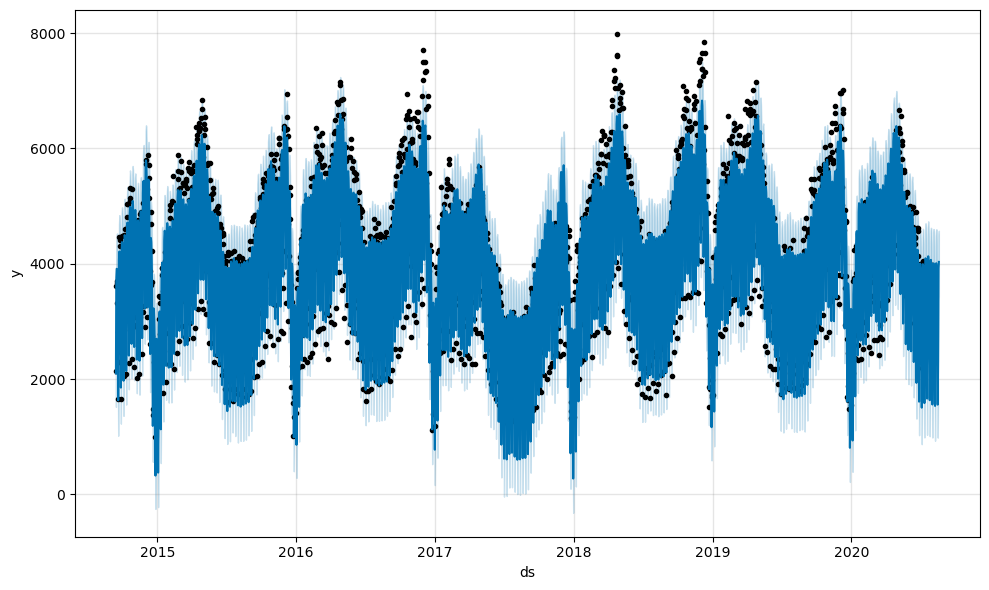

In [83]:
fig1 = model_prophet.plot(prophet_preds)


А здесь - иллюстрация компонент

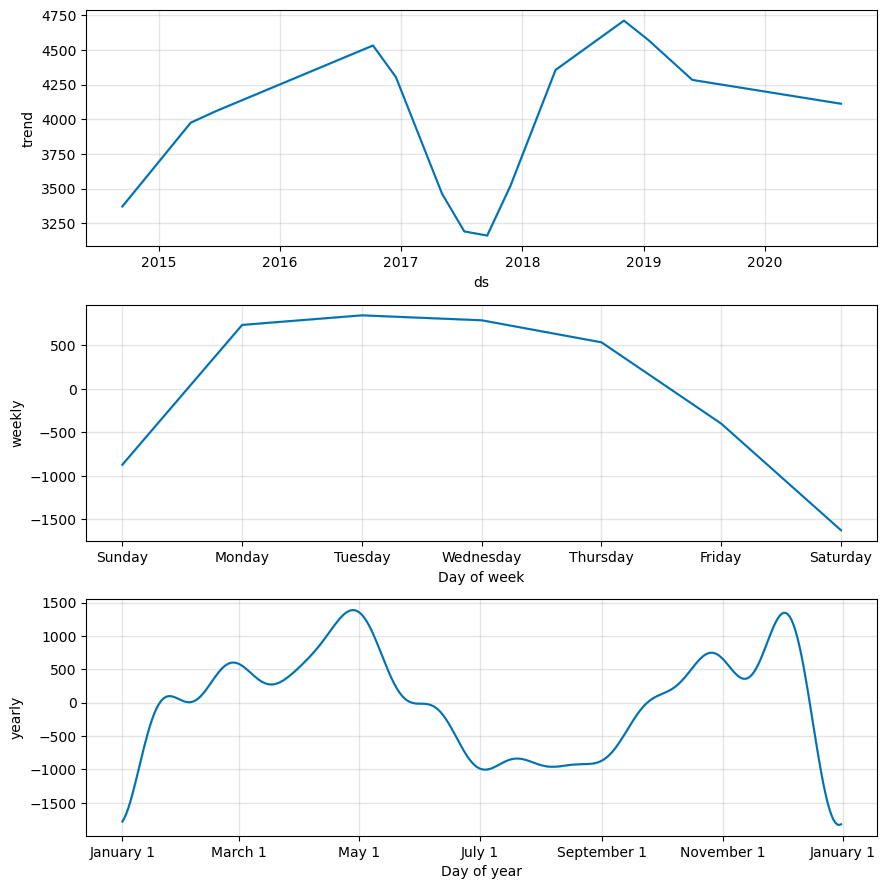

In [84]:
fig1 = model_prophet.plot_components(prophet_preds)


Можно также получить динамическую визуализацию:

In [85]:
from prophet.plot import plot_plotly, plot_components_plotly

In [86]:
plot_plotly(model_prophet, prophet_preds)


## Итоги

- Обсудили задачу прогноза временных рядов
- С помощью pandas, seaborn и matplotlib изучили временнной ряд
- Попробовали самостоятельно разложить ряд
- Познакомились со statsmodels и разложили ряд функцией из этой библиотеки
- Спрогнозировали ряд с помощью библиотеки Prophet

# Бонус: Сравнение с ML-моделями

На курсе были практики по ML-моделям. Для обучения регресионной модели требовалась таблица с признаками, в котором каждая строка - это один прецедент, т.е. объект с признаковым описанием и значения таргета.

В данном случае у нас всего лишь один ряд - количество загрузок страницы. Можно ли из нее сделать признаки? Легко!
Будем считать лаги для момента времени $t$. Лаг - предыдущее значение ряда. Но можно считать не просто предыдущее, $t-1$, а на два шага назад. И на три. И на четыре.

Мы придем к модели вида $y_t = f(y_{t-1}, y_{t-2}, ..., y_{t-p})$ - к авторегрессии, т.е. к регрессии величине на саму себя в прошлые периоды.

### Создание фич

In [87]:
X = df['page_loads'].shift(1)
X.head()

date
2014-09-14       NaN
2014-09-15    2146.0
2014-09-16    3621.0
2014-09-17    3698.0
2014-09-18    3667.0
Name: page_loads, dtype: float64

In [88]:
X = X.reset_index().rename(columns={'page_loads': 'shift_1'})
X.head()

date  shift_1
0 2014-09-14      NaN
1 2014-09-15   2146.0
2 2014-09-16   3621.0
3 2014-09-17   3698.0
4 2014-09-18   3667.0

In [89]:
for i in range(2, 10):
    new_col = df['page_loads'].shift(i)
    X['shift_'+ str(i)] = new_col

In [90]:
X = df['page_loads'].reset_index()
for i in range(1, 11):
    X['shift_' + str(i)] = X['page_loads'].shift(i)

X = X.drop(columns=['page_loads']).dropna(axis=0, how='any')

### Разбиение данных

**Задание**

- разбейте данные на две части: train и test по division_date
- всего должно получится 4 переменных: X_train, X_test, y_train, y_test
- не забудьте! При создании Х мы удалили первые 10 строк (потеря данных из-за шифтов)

In [91]:
# место для кода

In [92]:
X_train = X[X['date'] < division_date].drop('date', axis=1)
X_test = X[X['date'] >= division_date].drop('date', axis=1)

y_train = train_data[10:]
y_test = test_data

### Обучение линейной регрессии

In [93]:
from sklearn.linear_model import LinearRegression

**Задание**

- давайте обучим линейную регрессию!
- и запишем прогнозы в переменную y_pred_lin

In [94]:
# место для кода

In [95]:
# вариант реализации
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)
y_pred_lin = model_linear.predict(X_test)

**Задание**

- рассчитайте MAE и $R_2$ для сделанных прогнозов
- как вы оцениваете качество модели?

In [96]:
# место для кода

In [97]:
# вариант реализации
print('MAE прогноза:', mae(test_data, y_pred_lin))
print('R2 модели:', r2_score(test_data, y_pred_lin))

MAE прогноза: 116.08527566095414
R2 модели: 0.9446720549347156


In [98]:
y_pred_lin = pd.Series(y_pred_lin, index=test_data.index)

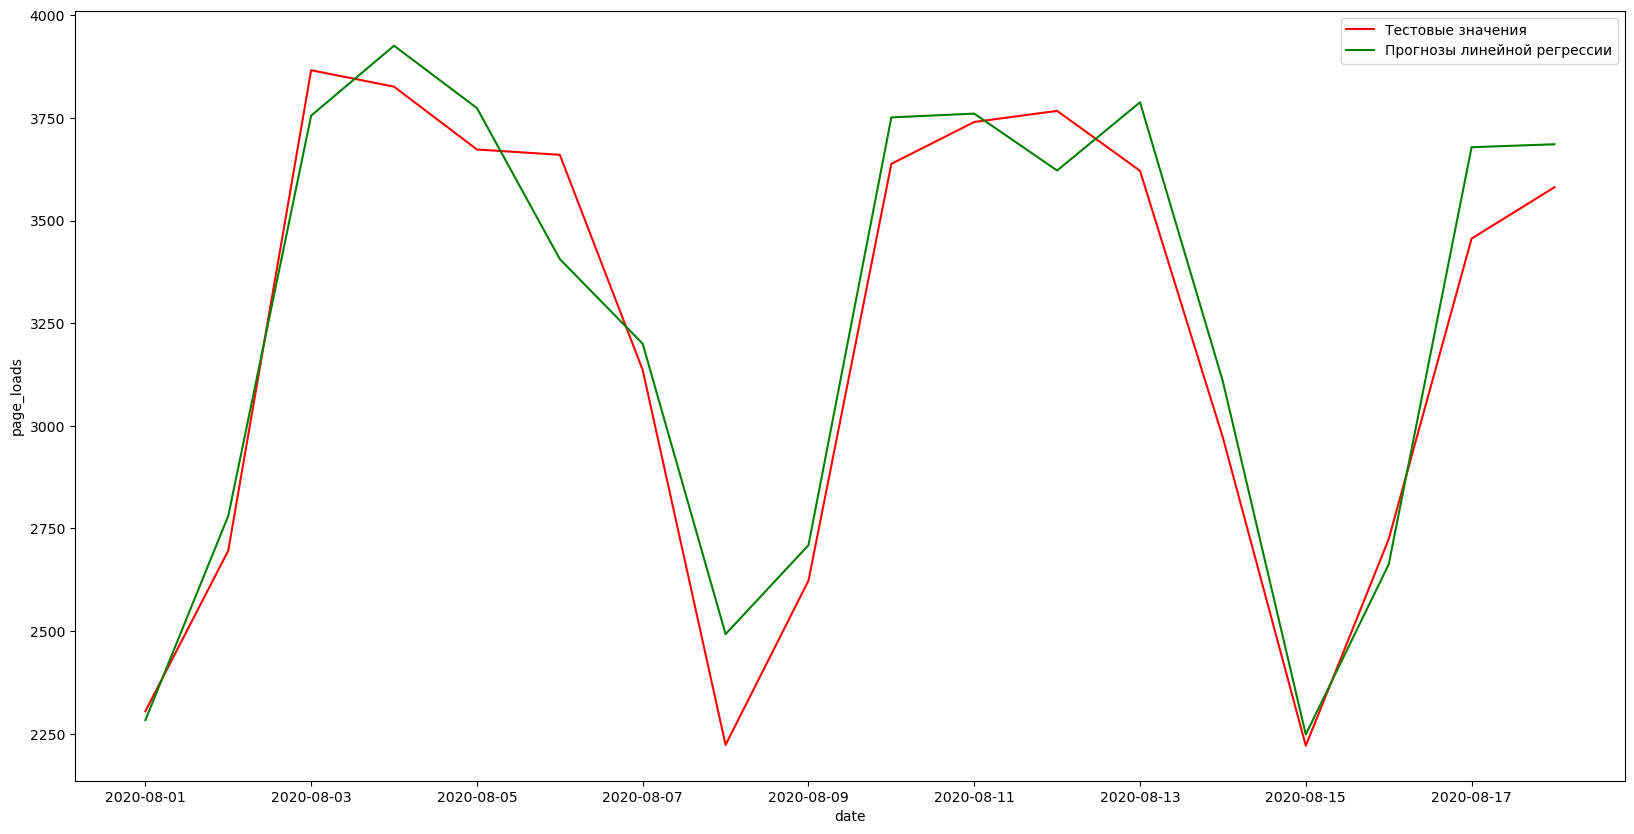

In [99]:
plt.figure(figsize=(20, 10))
sns.lineplot(test_data, color = "red", label='Тестовые значения')
sns.lineplot(y_pred_lin, color = "green", label='Прогнозы линейной регрессии')

plt.show()

Честный ли прогноз? Конечно, нет, он построен на +1 период вперед на 10 прошлых, поэтому красиво повторяется линия настоящих значений.

In [100]:
X_test

shift_1  shift_2  shift_3  shift_4  shift_5  shift_6  shift_7  shift_8  \
2148   3005.0   3397.0   3903.0   3795.0   4001.0   2835.0   2400.0   3430.0   
2149   2305.0   3005.0   3397.0   3903.0   3795.0   4001.0   2835.0   2400.0   
2150   2696.0   2305.0   3005.0   3397.0   3903.0   3795.0   4001.0   2835.0   
2151   3866.0   2696.0   2305.0   3005.0   3397.0   3903.0   3795.0   4001.0   
2152   3826.0   3866.0   2696.0   2305.0   3005.0   3397.0   3903.0   3795.0   
2153   3673.0   3826.0   3866.0   2696.0   2305.0   3005.0   3397.0   3903.0   
2154   3660.0   3673.0   3826.0   3866.0   2696.0   2305.0   3005.0   3397.0   
2155   3136.0   3660.0   3673.0   3826.0   3866.0   2696.0   2305.0   3005.0   
2156   2223.0   3136.0   3660.0   3673.0   3826.0   3866.0   2696.0   2305.0   
2157   2623.0   2223.0   3136.0   3660.0   3673.0   3826.0   3866.0   2696.0   
2158   3638.0   2623.0   2223.0   3136.0   3660.0   3673.0   3826.0   3866.0   
2159   3740.0   3638.0   2623.0   2223.0   3136.0   3660.0   3673.0   3826.0   
2160   3767.0   3740.0   3638.0   2623.0   2223.0   3136.0   3660.0   3673.0   
2161   3621.0   3767.0   3740.0   3638.0   2623.0   2223.0   3136.0   3660.0   
2162   2971.0   3621.0   3767.0   3740.0   3638.0   2623.0   2223.0   3136.0   
2163   2221.0   2971.0   3621.0   3767.0   3740.0   3638.0   2623.0   2223.0   
2164   2724.0   2221.0   2971.0   3621.0   3767.0   3740.0   3638.0   2623.0   
2165   3456.0   2724.0   2221.0   2971.0   3621.0   3767.0   3740.0   3638.0   

      shift_9  shift_10  
2148   3823.0    4002.0  
2149   3430.0    3823.0  
2150   2400.0    3430.0  
2151   2835.0    2400.0  
2152   4001.0    2835.0  
2153   3795.0    4001.0  
2154   3903.0    3795.0  
2155   3397.0    3903.0  
2156   3005.0    3397.0  
2157   2305.0    3005.0  
2158   2696.0    2305.0  
2159   3866.0    2696.0  
2160   3826.0    3866.0  
2161   3673.0    3826.0  
2162   3660.0    3673.0  
2163   3136.0    3660.0  
2164   2223.0    3136.0  
2165   2623.0    2223.0

Сделаем честную тестовую выборку!

In [101]:
y_pred_fair = np.zeros(len(y_test)) # здесь будем хранить честные прогнозы

X_test_fair = np.zeros(X_test.shape)
X_test_fair[0] = X_test.values[0]

for i in range(len(y_test)):
    X_fair = X_test_fair[i].reshape(1, -1)
    y_fair = model_linear.predict(X_fair)
    
    y_pred_fair[i] = y_fair

    if i < len(y_test) - 1:
        X_test_fair[i + 1, 0] = y_fair
        X_test_fair[i + 1, 1:] = X_test_fair[i, :-1]

/Users/elentevanyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

/Users/elentevanyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

/Users/elentevanyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

/Users/elentevanyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

/Users/elentevanyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

/Users/elentevanyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/

In [102]:
# вариант реализации
print('MAE прогноза:', mae(test_data, y_pred_fair))
print('R2 модели:', r2_score(test_data, y_pred_fair))

MAE прогноза: 245.98810696536384
R2 модели: 0.7148161224974737


In [103]:
y_pred_fair = pd.Series(y_pred_lin, index=test_data.index)

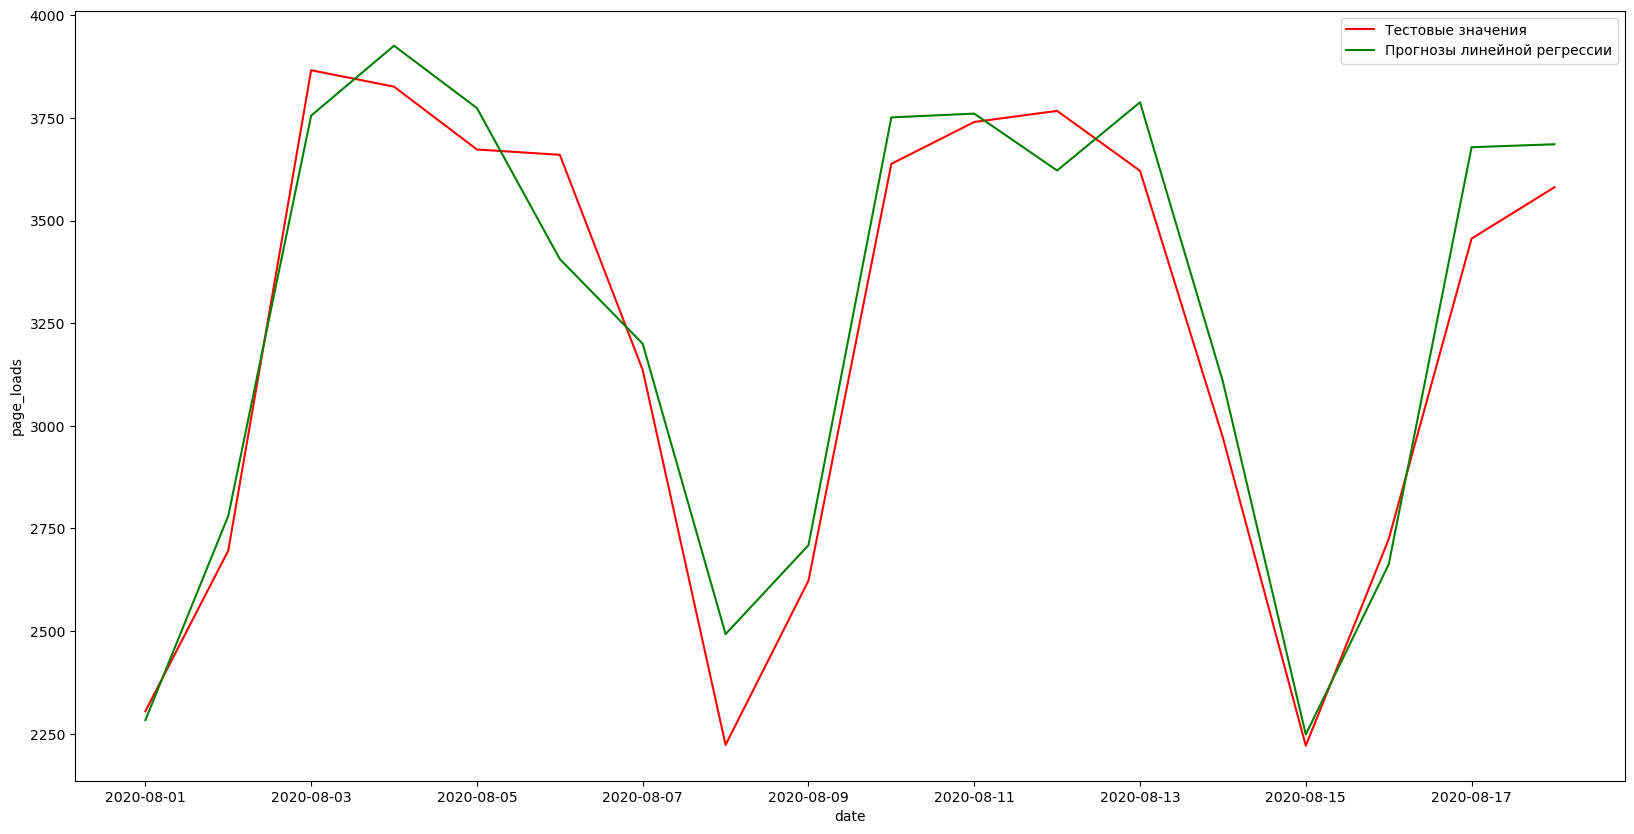

In [104]:
plt.figure(figsize=(20, 10))
sns.lineplot(test_data, color = "red", label='Тестовые значения')
sns.lineplot(y_pred_fair, color = "green", label='Прогнозы линейной регрессии')

plt.show()

# Бонус: Проверка на стационарность

### Стационарность

Стационарность временного ряда — это свойство, которое означает, что статистические характеристики ряда не изменяются со временем. В более формальном смысле, временной ряд считается стационарным, если выполняются следующие условия:

- Постоянство среднего (mean stationarity):

Среднее значение ряда остается постоянным на протяжении всего времени.
- Постоянство дисперсии (variance stationarity):

Дисперсия (или стандартное отклонение) ряда остается постоянной в течение всего времени.
- Постоянство автокорреляции (autocorrelation stationarity):
Автокорреляция между значениями ряда на различных временных точках остается постоянной.

**Если просто, то**:
- у ряда нет тренда
- у ряда нет сезонности
- при этом амлитуда колебаний ряда стабильная


Вспомним, как выглядит наш ряд и попробуем визуально оценить стационарность ряда.

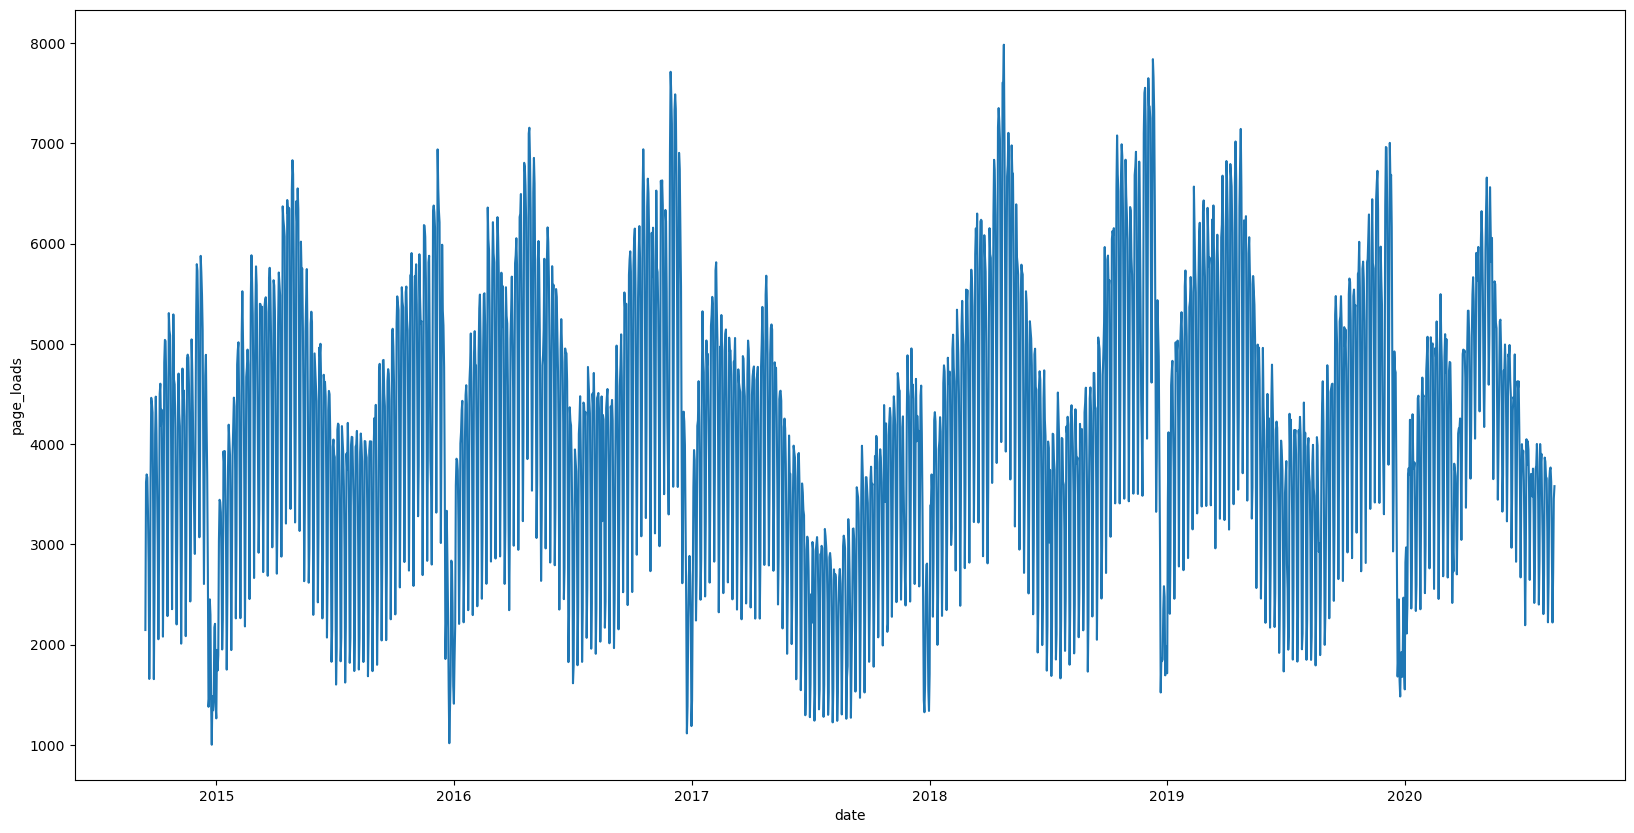

In [105]:
# вариант реализации
plt.figure(figsize=(20, 10))
sns.lineplot(data=df, x='date', y='page_loads')
plt.show()

Для более точно оценки можно применить тест Дики-Фуллера (Dickey-Fuller test).
Система гипотез теста:

- Нулевая гипотеза предполагает, что процесс нестационарный
- Альтернативная гипотеза соответственно говорит об обратном

In [106]:
from statsmodels.tsa.stattools import adfuller

In [107]:
adf_test = adfuller(df['page_loads'])
 
# выведем p-value
print('p-value = ' + str(adf_test[1]))

p-value = 0.00029218792027459623


Чуть выше появилось важное понятие - автокорреляция. **Автокорреляция**  показывает степень взаимосвязи в диапазоне от –1 до 1, как и корреляции, но только не двух переменных, а одной и той же переменной в разные моменты времени.

Автокорреляционная функция 1 - корреляция между рядом $y_t$ и $y_{t-1}$
Автокорреляционная функция 2 - корреляция между рядом $y_t$ и $y_{t-2}$
и т.д. 

Воспользуемся готовой функцией для визуализации автокорреляций:

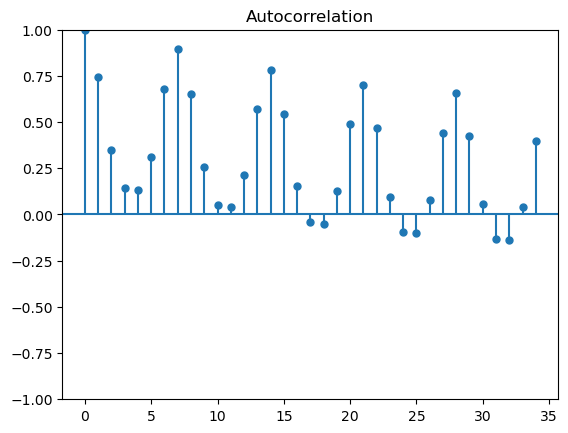

In [108]:
from statsmodels.graphics.tsaplots import plot_acf
 
# применим функцию к нашему набору данных
plot_acf(df['page_loads'], alpha = None)
plt.show()

Автокорреляционные функции оказываются полезными при работе со следующим семейством моделей

# Бонус: SARIMA

Модель SARIMA - представитель семейства авторегрессионных моделей.

Она состоит из нескольких кирпичиков:

- AR(p) - это регрессия ряда на собственные значения в прошлом. Другими словами, наши признаки в модели обычной регрессии мы заменяем значениями той же переменной, но за предыдущие периоды.

    $$y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \ldots + \phi_p y_{t-p} + \varepsilon_t$$
    - $y_t$ - значение временного ряда в момент времени $t$,
    - $c$ - константа,
    - $\phi_1, \phi_2, \ldots, \phi_p$ - параметры авторегрессии,
    - $y_{t-1}, y_{t-2}, \ldots, y_{t-p}$ - значения временного ряда в предыдущих моментах времени,
    - $\varepsilon_t$ - случайная ошибка в момент времени $t$.

- MA(q) - модель скользящего среднего (moving average, MA) помогает учесть случайные колебания или отклонения (ошибки) истинного значения от прогнозного. Можно также сказать, что модель скользящего среднего — это авторегрессия на ошибку.

    $$y_t = \mu + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \ldots + \theta_q \varepsilon_{t-q}$$
    - $y_t$ - значение временного ряда в момент времени $t$,
    - $\mu$ - среднее значение временного ряда,
    - $\varepsilon_t$ - случайная ошибка в момент времени $t$,
    - $\theta_1, \theta_2, \ldots, \theta_q$ - параметры скользящего среднего,
    - $\varepsilon_{t-1}, \varepsilon_{t-2}, \ldots, \varepsilon_{t-q}$ - значения ошибок в предыдущих моментах времени.

- $I$ обозначает Integrated (I) - специальная процедура, который отвечает за удаление тренда (сам процесс называется дифференцированием). Он нужен для того, чтобы сделать ряд стационарным (а это одно из условий для ARMA-модели). Задается параметр $d$, сколько раз надо продифференцировать исходный ряд, чтобы он стал стационарным.

- $S$ отвечает за сезонность(Seasonality, S). Этот "кирпичик" добавляет еще три параметра $P, Q, D$, описывающих сезонность каждого из предыдущих "кирпичиков"

In [109]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
 
# создадим объект этой модели
model = SARIMAX(train_data, order= (2, 0, 1), seasonal_order=(3, 0, 3, 12))
 
# применим метод fit
result = model.fit()

/Users/elentevanyan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/elentevanyan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/elentevanyan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/elentevanyan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.88857D+00    |proj g|=  1.55347D+00

At iterate    5    f=  8.03143D+00    |proj g|=  2.16528D-01

At iterate   10    f=  7.92031D+00    |proj g|=  4.46451D-02

At iterate   15    f=  7.90188D+00    |proj g|=  5.04876D-02

At iterate   20    f=  7.90107D+00    |proj g|=  5.39851D-02

At iterate   25    f=  7.90008D+00    |proj g|=  4.01418D-02

At iterate   30    f=  7.89970D+00    |proj g|=  5.17853D-02

At iterate   35    f=  7.89862D+00    |proj g|=  8.10149D-02

At iterate   40    f=  7.89821D+00    |proj g|=  4.30014D-03

At iterate   45    f=  7.89771D+00    |proj g|=  2.50001D-02


/Users/elentevanyan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  7.89641D+00    |proj g|=  2.75343D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     56      1     0     0   2.753D-02   7.896D+00
  F =   7.8964128924254817     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [110]:
start = test_data.index[0]
end = test_data.index[-1]

In [111]:
sarima_pred = result.predict(start, end)
sarima_pred.shape


(18,)

In [112]:
sarima_pred = pd.DataFrame(list(sarima_pred)).rename(columns={0:'values'})
sarima_pred.set_index(test_data.index, inplace=True)

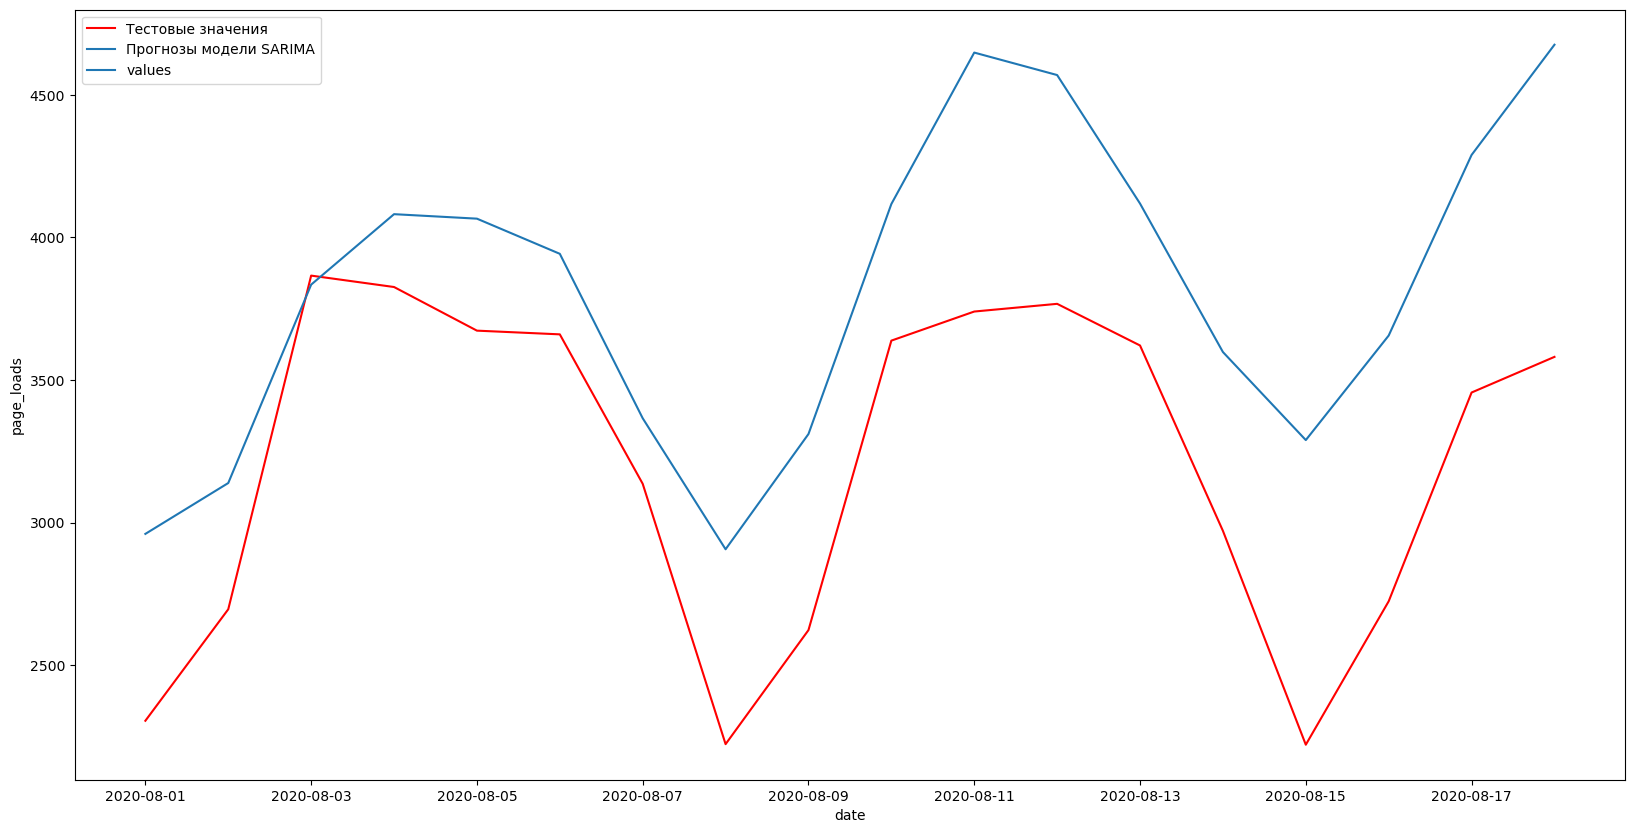

In [113]:
plt.figure(figsize=(20, 10))
sns.lineplot(test_data, color = "red", label='Тестовые значения')
sns.lineplot(sarima_pred, color = "green", label='Прогнозы модели SARIMA')

plt.show()

In [114]:
print('MAE прогноза:', mae(test_data, sarima_pred))
print('R2 модели:', r2_score(test_data, sarima_pred))

MAE прогноза: 605.7078386447306
R2 модели: -0.3491899254814814


- В модели много гиперпараметров: надо крутить и подбирать => долго считается
- Сходу получить приемлемый результат - трудно